# Framework Benchmark: RadiObject vs MONAI vs TorchIO

Publication-quality benchmark comparing medical imaging data loading frameworks across multiple storage backends.

## Storage Backends Matrix

| Backend | RadiObject | MONAI | TorchIO | S3 Support |
|---------|------------|-------|---------|------------|
| TileDB (AXIAL) | ✅ | — | — | ✅ Native |
| TileDB (ISOTROPIC) | ✅ | — | — | ✅ Native |
| NIfTI compressed (.nii.gz) | — | ✅ | ✅ | ❌ Download first |
| NIfTI uncompressed (.nii) | — | ✅ | ✅ | ❌ Download first |
| NumPy (.npy) | — | ✅ | ✅ | ❌ Download first |

**Key insight**: NumPy backend isolates framework overhead from file format parsing.

## Metrics Measured

| Category | Metrics |
|----------|---------|
| **Disk Space** | Bytes per format, compression ratio |
| **Memory** | Heap (tracemalloc), RSS (psutil), peak vs sustained |
| **I/O Time** | Full volume, partial read, random access |
| **ML Training** | DataLoader throughput, GPU memory (if available) |

## Benchmark Categories

| Category | Focus | RadiObject Advantage |
|----------|-------|---------------------|
| **0. Dataset Prep** | Create all storage formats | Measure disk space |
| **1. Storage Formats** | Format overhead comparison | — |
| **2. Data Loading** | Core I/O performance | Partial reads, O(1) indexing |
| **3. Analysis** | In-notebook exploration | Metadata queries |
| **4. ML Training** | DataLoader throughput | Patch extraction |
| **5. S3 Cloud** | Remote data access | Native S3 support (unique) |

## Frameworks

| Framework | Primary Use | Storage Model |
|-----------|-------------|---------------|
| **RadiObject** | TileDB-backed radiology atlas | Local + S3 native |
| **MONAI** | Medical imaging DL | NIfTI/DICOM files |
| **TorchIO** | Medical imaging augmentation | NIfTI files |

## 1. Environment Setup

In [1]:
# Parameters (papermill)
BATCH_SIZE = 4
PATCH_SIZE = (64, 64, 64)
NUM_WORKERS = 0
N_WARMUP = 5  # Increased from 3 for better warm cache
N_BATCHES = 20
N_RUNS = 10  # Increased from 5 for statistical rigor
S3_BUCKET = "souzy-scratch"
RUN_S3_BENCHMARKS = True
OUTPUT_DIR = "../assets/benchmark"
N_SUBJECTS_FOR_TILED = 20  # Subjects for benchmark datasets
RANDOM_SEED = 42  # Fixed seed for reproducibility

In [2]:
import gc
import hashlib
import json
import os
import platform
import random
import shutil
import subprocess
import sys
import threading
import time
import tracemalloc
from dataclasses import dataclass, field
from datetime import datetime
from pathlib import Path
from typing import Callable

import psutil

sys.path.insert(0, "..")

# Fix random seeds for reproducibility
random.seed(RANDOM_SEED)

print("=" * 60)
print("MACHINE SPECIFICATIONS")
print("=" * 60)
print(f"Timestamp: {datetime.now().isoformat()}")
print(f"Platform: {platform.platform()}")
print(f"Python: {platform.python_version()}")

try:
    chip = subprocess.check_output(["sysctl", "-n", "machdep.cpu.brand_string"], text=True).strip()
    print(f"CPU: {chip}")
except Exception:
    print(f"CPU: {platform.processor()}")

print(
    f"CPU Cores: {psutil.cpu_count(logical=False)} physical, "
    f"{psutil.cpu_count(logical=True)} logical"
)
print(f"RAM: {psutil.virtual_memory().total / (1024**3):.1f} GB")

# Check for GPU
HAVE_CUDA = False
try:
    import torch

    if torch.cuda.is_available():
        HAVE_CUDA = True
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"  CUDA: {torch.version.cuda}")
        print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.1f} GB")
    else:
        print("GPU: Not available (CUDA not detected)")
except ImportError:
    print("GPU: Not available (PyTorch not installed)")

print("=" * 60)

MACHINE SPECIFICATIONS
Timestamp: 2026-01-30T22:46:54.154469
Platform: macOS-26.0-arm64-arm-64bit
Python: 3.11.14
CPU: Apple M5
CPU Cores: 10 physical, 10 logical
RAM: 24.0 GB


GPU: Not available (CUDA not detected)


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

# Fix numpy seed
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print(f"NumPy: {np.__version__}")
print(f"PyTorch: {torch.__version__}")

HAVE_MONAI = False
HAVE_TORCHIO = False
HAVE_SIMPLEITK = False

try:
    import monai
    from monai.data import DataLoader as MonaiDataLoader
    from monai.data import Dataset as MonaiDataset
    from monai.transforms import (
        Compose,
        EnsureChannelFirstd,
        LoadImaged,
        RandSpatialCropd,
    )

    HAVE_MONAI = True
    print(f"MONAI: {monai.__version__}")
except ImportError:
    print("MONAI: Not installed")

try:
    import torchio as tio

    HAVE_TORCHIO = True
    print(f"TorchIO: {tio.__version__}")
except ImportError:
    print("TorchIO: Not installed")

try:
    import SimpleITK as sitk

    HAVE_SIMPLEITK = True
    print(f"SimpleITK: {sitk.__version__}")
except ImportError:
    print("SimpleITK: Not installed")

import nibabel as nib

from radiobject import RadiObject, configure
from radiobject.ctx import S3Config, SliceOrientation, TileConfig
from radiobject.ml import create_training_dataloader

print("\nRadiObject: Loaded")

NumPy: 2.4.1
PyTorch: 2.10.0


MONAI: 1.5.2
TorchIO: 0.21.2
SimpleITK: 2.5.3



RadiObject: Loaded


In [4]:
from config import S3_REGION

# Paths relative to benchmarks/ directory
DATA_DIR = Path("../data")
NIFTI_DIR = DATA_DIR / "msd_lung" / "Task06_Lung" / "imagesTr"
ASSETS_DIR = Path("../assets/benchmark")
BENCHMARK_DIR = DATA_DIR / "benchmark"

# URIs for different storage formats
LOCAL_AXIAL_URI = str(BENCHMARK_DIR / "radiobject-axial")
LOCAL_ISOTROPIC_URI = str(BENCHMARK_DIR / "radiobject-isotropic")
NIFTI_COMPRESSED_DIR = BENCHMARK_DIR / "nifti-compressed"
NIFTI_UNCOMPRESSED_DIR = BENCHMARK_DIR / "nifti-uncompressed"
NUMPY_DIR = BENCHMARK_DIR / "numpy"

S3_AXIAL_URI = f"s3://{S3_BUCKET}/benchmark/radiobject-axial"
S3_ISOTROPIC_URI = f"s3://{S3_BUCKET}/benchmark/radiobject-isotropic"

# Create directories
DATA_DIR.mkdir(parents=True, exist_ok=True)
ASSETS_DIR.mkdir(parents=True, exist_ok=True)
BENCHMARK_DIR.mkdir(parents=True, exist_ok=True)

print(f"Batch size: {BATCH_SIZE}")
print(f"Patch size: {PATCH_SIZE}")
print(f"Warmup iterations: {N_WARMUP}")
print(f"Benchmark batches: {N_BATCHES}")
print(f"Runs per framework: {N_RUNS}")
print(f"Random seed: {RANDOM_SEED}")
print("\nLocal URIs:")
print(f"  TileDB Axial: {LOCAL_AXIAL_URI}")
print(f"  TileDB Isotropic: {LOCAL_ISOTROPIC_URI}")
print(f"  NIfTI compressed: {NIFTI_COMPRESSED_DIR}")
print(f"  NIfTI uncompressed: {NIFTI_UNCOMPRESSED_DIR}")
print(f"  NumPy: {NUMPY_DIR}")
print("\nS3 URIs:")
print(f"  Axial: {S3_AXIAL_URI}")
print(f"  Isotropic: {S3_ISOTROPIC_URI}")
print(f"\nSource NIfTI directory: {NIFTI_DIR}")

Batch size: 4
Patch size: (64, 64, 64)
Warmup iterations: 5
Benchmark batches: 20
Runs per framework: 10
Random seed: 42

Local URIs:
  TileDB Axial: ../data/benchmark/radiobject-axial
  TileDB Isotropic: ../data/benchmark/radiobject-isotropic
  NIfTI compressed: ../data/benchmark/nifti-compressed
  NIfTI uncompressed: ../data/benchmark/nifti-uncompressed
  NumPy: ../data/benchmark/numpy

S3 URIs:
  Axial: s3://souzy-scratch/benchmark/radiobject-axial
  Isotropic: s3://souzy-scratch/benchmark/radiobject-isotropic

Source NIfTI directory: ../data/msd_lung/Task06_Lung/imagesTr


## 2. Benchmark Infrastructure

Enhanced with CPU, memory, GPU profiling, and disk space measurement.

In [5]:
class CPUSampler:
    """Sample CPU utilization during an operation."""

    def __init__(self, interval_ms: int = 100):
        self.interval = interval_ms / 1000
        self.samples: list[float] = []
        self._stop = False
        self._thread: threading.Thread | None = None

    def start(self) -> None:
        self._stop = False
        self.samples = []
        self._thread = threading.Thread(target=self._sample, daemon=True)
        self._thread.start()

    def _sample(self) -> None:
        while not self._stop:
            self.samples.append(psutil.cpu_percent(interval=None))
            time.sleep(self.interval)

    def stop(self) -> tuple[float, float]:
        self._stop = True
        if self._thread:
            self._thread.join(timeout=1.0)
        if self.samples:
            return float(np.mean(self.samples)), float(max(self.samples))
        return 0.0, 0.0

    def __enter__(self) -> "CPUSampler":
        self.start()
        return self

    def __exit__(self, *args) -> None:
        self.stop()

In [6]:
@dataclass
class BenchmarkResult:
    """Single benchmark run result with comprehensive profiling."""

    framework: str
    benchmark_name: str
    scenario: str  # "local" or "s3"
    tiling_strategy: str = ""  # "axial" or "isotropic"
    storage_format: str = ""  # "tiledb", "nifti_gz", "nifti", "numpy"

    # Timing
    time_mean_ms: float = 0.0
    time_std_ms: float = 0.0
    cold_start_ms: float = 0.0
    batch_times_ms: list[float] = field(default_factory=list)

    # CPU metrics
    cpu_percent_mean: float = 0.0
    cpu_percent_peak: float = 0.0

    # Memory metrics (CPU)
    peak_heap_mb: float = 0.0  # tracemalloc
    peak_rss_mb: float = 0.0  # psutil

    # GPU metrics
    peak_gpu_allocated_mb: float = 0.0  # torch.cuda.max_memory_allocated
    peak_gpu_reserved_mb: float = 0.0  # torch.cuda.max_memory_reserved

    # Disk metrics
    disk_size_mb: float = 0.0

    # Throughput
    throughput_samples_per_sec: float = 0.0
    throughput_mb_per_sec: float = 0.0

    # Metadata
    data_size_mb: float = 0.0
    n_samples: int = 0
    timestamp: str = field(default_factory=lambda: datetime.now().isoformat())

    def to_dict(self) -> dict:
        return {
            "framework": self.framework,
            "benchmark_name": self.benchmark_name,
            "scenario": self.scenario,
            "tiling_strategy": self.tiling_strategy,
            "storage_format": self.storage_format,
            "time_mean_ms": round(self.time_mean_ms, 3),
            "time_std_ms": round(self.time_std_ms, 3),
            "cold_start_ms": round(self.cold_start_ms, 3),
            "cpu_percent_mean": round(self.cpu_percent_mean, 1),
            "cpu_percent_peak": round(self.cpu_percent_peak, 1),
            "peak_heap_mb": round(self.peak_heap_mb, 2),
            "peak_rss_mb": round(self.peak_rss_mb, 2),
            "peak_gpu_allocated_mb": round(self.peak_gpu_allocated_mb, 2),
            "peak_gpu_reserved_mb": round(self.peak_gpu_reserved_mb, 2),
            "disk_size_mb": round(self.disk_size_mb, 2),
            "throughput_samples_per_sec": round(self.throughput_samples_per_sec, 2),
            "n_samples": self.n_samples,
        }


@dataclass
class DiskSpaceResult:
    """Disk space measurement for a storage format."""

    format_name: str
    path: str
    size_bytes: int
    size_mb: float
    n_files: int
    compression_ratio: float = 0.0  # vs raw voxel data
    raw_voxel_bytes: int = 0

    def to_dict(self) -> dict:
        return {
            "format_name": self.format_name,
            "path": self.path,
            "size_bytes": self.size_bytes,
            "size_mb": round(self.size_mb, 2),
            "n_files": self.n_files,
            "compression_ratio": round(self.compression_ratio, 3),
        }

In [7]:
def get_directory_size_bytes(path: Path) -> tuple[int, int]:
    """Recursively measure directory size. Returns (total_bytes, file_count)."""
    total = 0
    count = 0
    if path.is_file():
        return path.stat().st_size, 1
    for entry in path.rglob("*"):
        if entry.is_file():
            total += entry.stat().st_size
            count += 1
    return total, count


def get_directory_size_mb(path: Path) -> float:
    """Recursively measure directory size in MB."""
    size_bytes, _ = get_directory_size_bytes(path)
    return size_bytes / (1024 * 1024)


def create_uncompressed_nifti(src: Path, dst: Path) -> None:
    """Convert .nii.gz to .nii (uncompressed)."""
    img = nib.load(str(src))
    nib.save(img, str(dst))


def create_numpy_from_nifti(src: Path, dst: Path) -> None:
    """Convert NIfTI to .npy."""
    img = nib.load(str(src))
    data = img.get_fdata()
    np.save(str(dst), data)


def compute_raw_voxel_bytes(nifti_path: Path) -> int:
    """Compute raw voxel data size (uncompressed, no header)."""
    img = nib.load(str(nifti_path))
    shape = img.shape
    dtype = img.get_data_dtype()
    n_voxels = np.prod(shape)
    bytes_per_voxel = np.dtype(dtype).itemsize
    return int(n_voxels * bytes_per_voxel)


def compute_checksum(data: np.ndarray) -> str:
    """Compute MD5 checksum of array data for validation."""
    return hashlib.md5(data.tobytes()).hexdigest()


def measure_disk_space(
    path: Path,
    format_name: str,
    raw_voxel_bytes: int = 0,
) -> DiskSpaceResult:
    """Measure disk space for a storage format."""
    if not path.exists():
        return DiskSpaceResult(format_name, str(path), 0, 0.0, 0)

    size_bytes, n_files = get_directory_size_bytes(path)
    size_mb = size_bytes / (1024 * 1024)
    compression_ratio = raw_voxel_bytes / size_bytes if size_bytes > 0 else 0.0

    return DiskSpaceResult(
        format_name=format_name,
        path=str(path),
        size_bytes=size_bytes,
        size_mb=size_mb,
        n_files=n_files,
        compression_ratio=compression_ratio,
        raw_voxel_bytes=raw_voxel_bytes,
    )

In [8]:
def benchmark_operation(
    func: Callable,
    framework: str,
    benchmark_name: str,
    scenario: str = "local",
    tiling: str = "",
    storage_format: str = "",
    n_warmup: int = N_WARMUP,
    n_runs: int = N_RUNS,
    track_gpu: bool = False,
) -> BenchmarkResult:
    """Benchmark an operation with CPU, memory, and GPU profiling."""
    process = psutil.Process()
    gc.collect()

    # Reset GPU memory stats if tracking
    if track_gpu and HAVE_CUDA:
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.empty_cache()

    # Cold start with memory tracking
    tracemalloc.start()
    rss_before = process.memory_info().rss
    cpu_sampler = CPUSampler()
    cpu_sampler.start()

    cold_start = time.perf_counter()
    func()
    cold_time = (time.perf_counter() - cold_start) * 1000

    cpu_mean, cpu_peak = cpu_sampler.stop()
    _, peak_heap = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    rss_after = process.memory_info().rss

    # Capture GPU metrics after cold start
    gpu_allocated = 0.0
    gpu_reserved = 0.0
    if track_gpu and HAVE_CUDA:
        gpu_allocated = torch.cuda.max_memory_allocated() / (1024 * 1024)
        gpu_reserved = torch.cuda.max_memory_reserved() / (1024 * 1024)

    # Warmup (remaining iterations)
    for _ in range(n_warmup - 1):
        func()

    # Timed runs with GC between each
    times = []
    for _ in range(n_runs):
        gc.collect()
        start = time.perf_counter()
        func()
        times.append((time.perf_counter() - start) * 1000)

    return BenchmarkResult(
        framework=framework,
        benchmark_name=benchmark_name,
        scenario=scenario,
        tiling_strategy=tiling,
        storage_format=storage_format,
        time_mean_ms=float(np.mean(times)),
        time_std_ms=float(np.std(times)),
        cold_start_ms=cold_time,
        batch_times_ms=times,
        cpu_percent_mean=cpu_mean,
        cpu_percent_peak=cpu_peak,
        peak_heap_mb=peak_heap / (1024 * 1024),
        peak_rss_mb=(rss_after - rss_before) / (1024 * 1024),
        peak_gpu_allocated_mb=gpu_allocated,
        peak_gpu_reserved_mb=gpu_reserved,
        n_samples=n_runs,
    )

In [9]:
def benchmark_dataloader(
    loader: DataLoader,
    framework: str,
    benchmark_name: str,
    scenario: str,
    tiling: str = "",
    image_key: str = "image",
    n_warmup: int = N_WARMUP,
    n_batches: int = N_BATCHES,
) -> BenchmarkResult:
    """Benchmark a PyTorch DataLoader with CPU/memory profiling."""
    process = psutil.Process()
    gc.collect()
    tracemalloc.start()
    rss_before = process.memory_info().rss
    cpu_sampler = CPUSampler()
    cpu_sampler.start()

    # Cold start
    loader_iter = iter(loader)
    cold_start = time.perf_counter()
    first_batch = next(loader_iter)
    if isinstance(first_batch, dict):
        _ = first_batch[image_key].shape
    else:
        _ = first_batch.shape
    cold_start_time = (time.perf_counter() - cold_start) * 1000

    # Warmup
    for _ in range(n_warmup - 1):
        try:
            batch = next(loader_iter)
        except StopIteration:
            loader_iter = iter(loader)
            batch = next(loader_iter)

    # Benchmark batches
    batch_times = []
    for _ in range(n_batches):
        try:
            start = time.perf_counter()
            batch = next(loader_iter)
            if isinstance(batch, dict):
                _ = batch[image_key].shape
            else:
                _ = batch.shape
            batch_times.append((time.perf_counter() - start) * 1000)
        except StopIteration:
            break

    cpu_mean, cpu_peak = cpu_sampler.stop()
    _, peak_heap = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    rss_after = process.memory_info().rss

    mean_batch = float(np.mean(batch_times)) if batch_times else 0.0
    throughput = (BATCH_SIZE / (mean_batch / 1000)) if mean_batch > 0 else 0.0

    return BenchmarkResult(
        framework=framework,
        benchmark_name=benchmark_name,
        scenario=scenario,
        tiling_strategy=tiling,
        time_mean_ms=mean_batch,
        time_std_ms=float(np.std(batch_times)) if batch_times else 0.0,
        cold_start_ms=cold_start_time,
        batch_times_ms=batch_times,
        cpu_percent_mean=cpu_mean,
        cpu_percent_peak=cpu_peak,
        peak_heap_mb=peak_heap / (1024 * 1024),
        peak_rss_mb=(rss_after - rss_before) / (1024 * 1024),
        throughput_samples_per_sec=throughput,
        n_samples=len(batch_times) * BATCH_SIZE,
    )

## 3. Dataset Preparation

Create all storage formats from the same source data for fair comparison.

| Format | Directory | Description |
|--------|-----------|-------------|
| `radiobject-axial` | TileDB Group | AXIAL tiling (X, Y, 1) for 2D slices |
| `radiobject-isotropic` | TileDB Group | ISOTROPIC tiling (64³) for 3D ROI |
| `nifti-compressed` | .nii.gz files | Gzip compressed NIfTI |
| `nifti-uncompressed` | .nii files | Uncompressed NIfTI |
| `numpy` | .npy files | Raw NumPy arrays |

**Key insight**: NumPy backend isolates framework overhead from file format parsing.

In [10]:
# Find source NIfTI files
nifti_paths = []

if NIFTI_DIR.exists():
    nifti_paths = sorted(NIFTI_DIR.glob("*.nii.gz"))[:N_SUBJECTS_FOR_TILED]
    if nifti_paths:
        print(f"Found {len(list(NIFTI_DIR.glob('*.nii.gz')))} NIfTI files in {NIFTI_DIR}")
        sample = nib.load(str(nifti_paths[0]))
        print(f"  Sample: {nifti_paths[0].name}")
        print(f"  Shape: {sample.shape}")
        print(f"  Dtype: {sample.get_data_dtype()}")
        print(f"  Using first {N_SUBJECTS_FOR_TILED} for benchmark datasets")

        # Compute raw voxel size for compression ratio calculation
        raw_bytes = compute_raw_voxel_bytes(nifti_paths[0])
        print(f"  Raw voxel size per volume: {raw_bytes / (1024*1024):.1f} MB")
else:
    print(f"NIfTI directory not found: {NIFTI_DIR}")
    print("Please download MSD-Lung dataset first")

Found 63 NIfTI files in ../data/msd_lung/Task06_Lung/imagesTr
  Sample: lung_001.nii.gz
  Shape: (512, 512, 304)
  Dtype: float32
  Using first 20 for benchmark datasets
  Raw voxel size per volume: 304.0 MB


In [11]:
def prepare_all_storage_formats(
    source_niftis: list[Path],
    benchmark_dir: Path,
) -> dict[str, Path]:
    """Create all storage formats from source NIfTI files."""
    formats_created = {}

    if not source_niftis:
        print("No source NIfTI files available")
        return formats_created

    # 1. Create NIfTI compressed directory (symlinks to source)
    nifti_gz_dir = benchmark_dir / "nifti-compressed"
    if not nifti_gz_dir.exists():
        nifti_gz_dir.mkdir(parents=True)
        print(f"Creating NIfTI compressed links: {nifti_gz_dir}")
        for src in source_niftis:
            dst = nifti_gz_dir / src.name
            if not dst.exists():
                # Copy instead of symlink for accurate size measurement
                shutil.copy2(src, dst)
    else:
        print(f"NIfTI compressed exists: {nifti_gz_dir}")
    formats_created["nifti_gz"] = nifti_gz_dir

    # 2. Create uncompressed NIfTI
    nifti_dir = benchmark_dir / "nifti-uncompressed"
    if not nifti_dir.exists():
        nifti_dir.mkdir(parents=True)
        print(f"Creating NIfTI uncompressed: {nifti_dir}")
        for src in source_niftis:
            dst = nifti_dir / src.name.replace(".nii.gz", ".nii")
            if not dst.exists():
                create_uncompressed_nifti(src, dst)
                print(f"  Created: {dst.name}")
    else:
        print(f"NIfTI uncompressed exists: {nifti_dir}")
    formats_created["nifti"] = nifti_dir

    # 3. Create NumPy files
    numpy_dir = benchmark_dir / "numpy"
    if not numpy_dir.exists():
        numpy_dir.mkdir(parents=True)
        print(f"Creating NumPy: {numpy_dir}")
        for src in source_niftis:
            dst = numpy_dir / src.name.replace(".nii.gz", ".npy")
            if not dst.exists():
                create_numpy_from_nifti(src, dst)
                print(f"  Created: {dst.name}")
    else:
        print(f"NumPy exists: {numpy_dir}")
    formats_created["numpy"] = numpy_dir

    return formats_created


# Create all storage formats
print("=" * 60)
print("PREPARING STORAGE FORMATS")
print("=" * 60)
storage_formats = prepare_all_storage_formats(nifti_paths, BENCHMARK_DIR)
print()

PREPARING STORAGE FORMATS
NIfTI compressed exists: ../data/benchmark/nifti-compressed
NIfTI uncompressed exists: ../data/benchmark/nifti-uncompressed
NumPy exists: ../data/benchmark/numpy



In [12]:
def create_tiled_radiobject(
    uri: str,
    nifti_paths: list[Path],
    orientation: SliceOrientation,
    collection_name: str = "CT",
) -> RadiObject | None:
    """Create RadiObject with specific tiling strategy."""
    if not nifti_paths:
        print("No NIfTI files available")
        return None

    # Check if already exists
    if not uri.startswith("s3://") and Path(uri).exists():
        print(f"Loading existing: {uri}")
        return RadiObject(uri)

    print(f"Creating RadiObject with {orientation.value} tiling: {uri}")

    # Configure tiling
    configure(tile=TileConfig(orientation=orientation))

    # Create using from_niftis
    radi = RadiObject.from_niftis(
        uri=uri,
        image_dir=str(NIFTI_DIR),
        collection_name=collection_name,
    )

    print(f"  Created: {len(radi)} subjects")
    return radi

In [13]:
# Create local axial-tiled dataset
radi_local_axial = None
if nifti_paths:
    radi_local_axial = create_tiled_radiobject(
        LOCAL_AXIAL_URI,
        nifti_paths,
        SliceOrientation.AXIAL,
    )

if radi_local_axial:
    print("\nLocal AXIAL dataset ready:")
    print(f"  Subjects: {len(radi_local_axial)}")
    print(f"  Collections: {radi_local_axial.collection_names}")

Loading existing: ../data/benchmark/radiobject-axial



Local AXIAL dataset ready:
  Subjects: 63
  Collections: ('CT',)


In [14]:
# Create local isotropic-tiled dataset
radi_local_isotropic = None
if nifti_paths:
    radi_local_isotropic = create_tiled_radiobject(
        LOCAL_ISOTROPIC_URI,
        nifti_paths,
        SliceOrientation.ISOTROPIC,
    )

if radi_local_isotropic:
    print("\nLocal ISOTROPIC dataset ready:")
    print(f"  Subjects: {len(radi_local_isotropic)}")
    print(f"  Collections: {radi_local_isotropic.collection_names}")

Loading existing: ../data/benchmark/radiobject-isotropic

Local ISOTROPIC dataset ready:
  Subjects: 63
  Collections: ('CT',)


In [15]:
# Configure S3 and load/create S3 datasets
from config import AWS_PROFILE

radi_s3_axial = None
radi_s3_isotropic = None

if RUN_S3_BENCHMARKS:
    # Set AWS profile for boto3 credential lookup
    if AWS_PROFILE:
        os.environ["AWS_PROFILE"] = AWS_PROFILE
        print(f"Using AWS profile: {AWS_PROFILE}")

    configure(s3=S3Config(region=S3_REGION, max_parallel_ops=8))
    print(f"Configured S3 for region: {S3_REGION}")

    # Try to load existing S3 datasets
    try:
        radi_s3_axial = RadiObject(S3_AXIAL_URI)
        _ = len(radi_s3_axial)  # Force metadata load to verify dataset exists
        print(f"Loaded S3 AXIAL: {S3_AXIAL_URI}")
        print(f"  Subjects: {len(radi_s3_axial)}")
    except Exception as e:
        radi_s3_axial = None  # Ensure None if load failed
        print(f"S3 AXIAL not available: {type(e).__name__}")
        print("  To create: use RadiObject.from_niftis with S3 URI")

    try:
        radi_s3_isotropic = RadiObject(S3_ISOTROPIC_URI)
        _ = len(radi_s3_isotropic)  # Force metadata load to verify dataset exists
        print(f"Loaded S3 ISOTROPIC: {S3_ISOTROPIC_URI}")
        print(f"  Subjects: {len(radi_s3_isotropic)}")
    except Exception as e:
        radi_s3_isotropic = None  # Ensure None if load failed
        print(f"S3 ISOTROPIC not available: {type(e).__name__}")
else:
    print("S3 benchmarks disabled")

Using AWS profile: souzy-s3
Configured S3 for region: us-east-2


Loaded S3 AXIAL: s3://souzy-scratch/benchmark/radiobject-axial
  Subjects: 63
Loaded S3 ISOTROPIC: s3://souzy-scratch/benchmark/radiobject-isotropic
  Subjects: 63


In [16]:
import tiledb


def verify_tiling(uri: str, name: str) -> None:
    """Verify tile extents in a RadiObject volume."""
    try:
        radi = RadiObject(uri)
        vol = radi.collection(radi.collection_names[0]).iloc[0]
        schema = tiledb.ArraySchema.load(vol.uri)

        print(f"\n{name} ({uri.split('/')[-1]}):")
        print(f"  Volume shape: {vol.shape}")
        for i, dim in enumerate(schema.domain):
            print(f"  Dim {dim.name}: tile extent = {dim.tile}")
    except Exception as e:
        print(f"{name}: Not available ({type(e).__name__})")


verify_tiling(LOCAL_AXIAL_URI, "Local AXIAL")
verify_tiling(LOCAL_ISOTROPIC_URI, "Local ISOTROPIC")
if RUN_S3_BENCHMARKS:
    verify_tiling(S3_AXIAL_URI, "S3 AXIAL")
    verify_tiling(S3_ISOTROPIC_URI, "S3 ISOTROPIC")


Local AXIAL (radiobject-axial):
  Volume shape: (512, 512, 304)
  Dim x: tile extent = 512
  Dim y: tile extent = 512
  Dim z: tile extent = 1

Local ISOTROPIC (radiobject-isotropic):
  Volume shape: (512, 512, 304)
  Dim x: tile extent = 64
  Dim y: tile extent = 64
  Dim z: tile extent = 64
S3 AXIAL: Not available (TileDBError)
S3 ISOTROPIC: Not available (TileDBError)


In [17]:
# Measure disk space for all storage formats
print("=" * 60)
print("DISK SPACE COMPARISON")
print("=" * 60)

disk_space_results: list[DiskSpaceResult] = []

# Compute total raw voxel bytes
total_raw_bytes = 0
if nifti_paths:
    for p in nifti_paths:
        total_raw_bytes += compute_raw_voxel_bytes(p)
    print(f"Total raw voxel data: {total_raw_bytes / (1024**3):.2f} GB")
    print()

# Measure each format
format_paths = [
    ("TileDB (AXIAL)", Path(LOCAL_AXIAL_URI)),
    ("TileDB (ISOTROPIC)", Path(LOCAL_ISOTROPIC_URI)),
    ("NIfTI (.nii.gz)", NIFTI_COMPRESSED_DIR),
    ("NIfTI (.nii)", NIFTI_UNCOMPRESSED_DIR),
    ("NumPy (.npy)", NUMPY_DIR),
]

for name, path in format_paths:
    result = measure_disk_space(path, name, total_raw_bytes)
    if result.size_bytes > 0:
        disk_space_results.append(result)
        print(f"{name}:")
        print(f"  Size: {result.size_mb:.1f} MB ({result.n_files} files)")
        print(f"  Compression ratio: {result.compression_ratio:.2f}x")

# Summary table
if disk_space_results:
    print("\n--- Summary ---")
    df = pd.DataFrame([r.to_dict() for r in disk_space_results])
    display(df[["format_name", "size_mb", "n_files", "compression_ratio"]])

DISK SPACE COMPARISON
Total raw voxel data: 6.52 GB

TileDB (AXIAL):
  Size: 6220.0 MB (488 files)
  Compression ratio: 1.07x
TileDB (ISOTROPIC):
  Size: 5736.8 MB (488 files)
  Compression ratio: 1.16x
NIfTI (.nii.gz):
  Size: 2142.0 MB (20 files)
  Compression ratio: 3.12x
NIfTI (.nii):
  Size: 6678.0 MB (20 files)
  Compression ratio: 1.00x
NumPy (.npy):
  Size: 13356.0 MB (20 files)
  Compression ratio: 0.50x

--- Summary ---


,format_name,size_mb,n_files,compression_ratio
0,TileDB (AXIAL),6219.96,488,1.074
1,TileDB (ISOTROPIC),5736.80,488,1.164
2,NIfTI (.nii.gz),2141.98,20,3.118
3,NIfTI (.nii),6678.01,20,1.000
4,NumPy (.npy),13356.00,20,0.500


## 4. Category 1: Storage Format Comparison

**Purpose**: Isolate file format overhead from framework overhead.

| Test | What It Measures |
|------|------------------|
| NIfTI compressed vs uncompressed | Gzip decompression cost |
| NIfTI vs NumPy (same framework) | NIfTI parsing overhead |
| TileDB AXIAL vs ISOTROPIC | Tiling strategy impact |

In [18]:
# Storage for all results
all_results: list[BenchmarkResult] = []

# Get file paths for different formats
nifti_gz_paths = (
    sorted(NIFTI_COMPRESSED_DIR.glob("*.nii.gz")) if NIFTI_COMPRESSED_DIR.exists() else []
)
nifti_paths_uncompressed = (
    sorted(NIFTI_UNCOMPRESSED_DIR.glob("*.nii")) if NIFTI_UNCOMPRESSED_DIR.exists() else []
)
numpy_paths = sorted(NUMPY_DIR.glob("*.npy")) if NUMPY_DIR.exists() else []

print("Available benchmark files:")
print(f"  NIfTI compressed: {len(nifti_gz_paths)}")
print(f"  NIfTI uncompressed: {len(nifti_paths_uncompressed)}")
print(f"  NumPy: {len(numpy_paths)}")

Available benchmark files:
  NIfTI compressed: 20
  NIfTI uncompressed: 20
  NumPy: 20


In [19]:
def benchmark_storage_formats():
    """Benchmark 1.1: Storage Format Loading Comparison."""
    print("=" * 60)
    print("BENCHMARK 1.1: Storage Format Loading")
    print("=" * 60)
    print("What: Compare load times across file formats using the same framework")
    print("Insight: Isolates format parsing cost from framework overhead")
    print()

    results = []

    # --- NIfTI Compressed vs Uncompressed ---
    print("--- NIfTI: Gzip Decompression Cost ---")

    if nifti_gz_paths:
        result = benchmark_operation(
            lambda: nib.load(str(nifti_gz_paths[0])).get_fdata(),
            "nibabel",
            "format_comparison",
            "local",
            storage_format="nifti_gz",
        )
        results.append(result)
        print(
            f"NIfTI compressed (.nii.gz): {result.time_mean_ms:.1f} +/- {result.time_std_ms:.1f} ms"
        )
        print(f"  Memory: {result.peak_heap_mb:.1f} MB heap")

    if nifti_paths_uncompressed:
        result = benchmark_operation(
            lambda: nib.load(str(nifti_paths_uncompressed[0])).get_fdata(),
            "nibabel",
            "format_comparison",
            "local",
            storage_format="nifti",
        )
        results.append(result)
        print(
            f"NIfTI uncompressed (.nii): {result.time_mean_ms:.1f} +/- {result.time_std_ms:.1f} ms"
        )

    # Calculate gzip overhead
    nifti_gz_result = next((r for r in results if r.storage_format == "nifti_gz"), None)
    nifti_result = next((r for r in results if r.storage_format == "nifti"), None)
    if nifti_gz_result and nifti_result and nifti_result.time_mean_ms > 0:
        gzip_overhead = (nifti_gz_result.time_mean_ms / nifti_result.time_mean_ms - 1) * 100
        print(f"  Gzip overhead: {gzip_overhead:.1f}%")

    # --- NIfTI vs NumPy ---
    print("\n--- NIfTI vs NumPy: Format Parsing Cost ---")

    if numpy_paths:
        result = benchmark_operation(
            lambda: np.load(str(numpy_paths[0])),
            "numpy",
            "format_comparison",
            "local",
            storage_format="numpy",
        )
        results.append(result)
        print(f"NumPy (.npy): {result.time_mean_ms:.1f} +/- {result.time_std_ms:.1f} ms")
        print(f"  Memory: {result.peak_heap_mb:.1f} MB heap")

    numpy_result = next((r for r in results if r.storage_format == "numpy"), None)
    if nifti_result and numpy_result and numpy_result.time_mean_ms > 0:
        parsing_overhead = (nifti_result.time_mean_ms / numpy_result.time_mean_ms - 1) * 100
        print(f"  NIfTI parsing overhead vs NumPy: {parsing_overhead:.1f}%")

    # --- TileDB Tiling Comparison ---
    print("\n--- TileDB: Tiling Strategy ---")

    if radi_local_axial:
        vol = radi_local_axial.collection(radi_local_axial.collection_names[0]).iloc[0]
        result = benchmark_operation(
            lambda: vol.to_numpy(),
            "RadiObject",
            "format_comparison",
            "local",
            tiling="axial",
            storage_format="tiledb",
        )
        results.append(result)
        print(f"TileDB AXIAL: {result.time_mean_ms:.1f} +/- {result.time_std_ms:.1f} ms")

    if radi_local_isotropic:
        vol = radi_local_isotropic.collection(radi_local_isotropic.collection_names[0]).iloc[0]
        result = benchmark_operation(
            lambda: vol.to_numpy(),
            "RadiObject",
            "format_comparison",
            "local",
            tiling="isotropic",
            storage_format="tiledb",
        )
        results.append(result)
        print(f"TileDB ISOTROPIC: {result.time_mean_ms:.1f} +/- {result.time_std_ms:.1f} ms")

    print("\n--- Key Insights ---")
    print("1. Gzip adds decompression overhead but saves disk space")
    print("2. NIfTI header parsing adds modest overhead vs raw NumPy")
    print("3. TileDB tiling strategy has minimal impact on full-volume loads")

    return results


all_results.extend(benchmark_storage_formats())

BENCHMARK 1.1: Storage Format Loading
What: Compare load times across file formats using the same framework
Insight: Isolates format parsing cost from framework overhead

--- NIfTI: Gzip Decompression Cost ---


NIfTI compressed (.nii.gz): 457.3 +/- 25.6 ms
  Memory: 912.0 MB heap


NIfTI uncompressed (.nii): 38.2 +/- 2.0 ms
  Gzip overhead: 1096.5%

--- NIfTI vs NumPy: Format Parsing Cost ---


NumPy (.npy): 46.3 +/- 0.6 ms
  Memory: 608.0 MB heap
  NIfTI parsing overhead vs NumPy: -17.5%

--- TileDB: Tiling Strategy ---


TileDB AXIAL: 505.0 +/- 9.4 ms


TileDB ISOTROPIC: 120.1 +/- 1.6 ms

--- Key Insights ---
1. Gzip adds decompression overhead but saves disk space
2. NIfTI header parsing adds modest overhead vs raw NumPy
3. TileDB tiling strategy has minimal impact on full-volume loads


In [20]:
def benchmark_full_volume_load():
    """Benchmark 2.1: Full Volume Loading (Local and S3)."""
    print("=" * 60)
    print("BENCHMARK 2.1: Full Volume Load")
    print("=" * 60)
    print("What: Load complete 3D volume into memory")
    print("Expectation: MONAI/TorchIO optimized for NIfTI; RadiObject competitive")
    print()

    results = []

    # RadiObject Local (axial-tiled)
    if radi_local_axial:
        vol = radi_local_axial.collection(radi_local_axial.collection_names[0]).iloc[0]
        result = benchmark_operation(
            lambda: vol.to_numpy(), "RadiObject", "full_volume", "local", "axial", "tiledb"
        )
        results.append(result)
        print(
            f"RadiObject (local/axial): {result.time_mean_ms:.1f} +/- {result.time_std_ms:.1f} ms"
        )
        print(f"  CPU: {result.cpu_percent_mean:.1f}% mean, {result.cpu_percent_peak:.1f}% peak")
        print(f"  Memory: {result.peak_heap_mb:.1f} MB heap")

    # RadiObject S3 (if available)
    if radi_s3_axial:
        vol = radi_s3_axial.collection(radi_s3_axial.collection_names[0]).iloc[0]
        result = benchmark_operation(
            lambda: vol.to_numpy(), "RadiObject", "full_volume", "s3", "axial", "tiledb"
        )
        results.append(result)
        print(f"RadiObject (S3/axial): {result.time_mean_ms:.1f} +/- {result.time_std_ms:.1f} ms")

    # MONAI (local only - can't read S3 natively)
    if HAVE_MONAI and nifti_gz_paths:
        from monai.transforms import LoadImage

        loader = LoadImage(image_only=True)
        result = benchmark_operation(
            lambda: loader(str(nifti_gz_paths[0])), "MONAI", "full_volume", "local", "", "nifti_gz"
        )
        results.append(result)
        print(f"MONAI (local): {result.time_mean_ms:.1f} +/- {result.time_std_ms:.1f} ms")
        print(f"  CPU: {result.cpu_percent_mean:.1f}% mean")

    # TorchIO (local only)
    if HAVE_TORCHIO and nifti_gz_paths:
        result = benchmark_operation(
            lambda: tio.ScalarImage(str(nifti_gz_paths[0])).data,
            "TorchIO",
            "full_volume",
            "local",
            "",
            "nifti_gz",
        )
        results.append(result)
        print(f"TorchIO (local): {result.time_mean_ms:.1f} +/- {result.time_std_ms:.1f} ms")

    return results


all_results.extend(benchmark_full_volume_load())

BENCHMARK 2.1: Full Volume Load
What: Load complete 3D volume into memory
Expectation: MONAI/TorchIO optimized for NIfTI; RadiObject competitive



RadiObject (local/axial): 525.4 +/- 9.7 ms
  CPU: 67.1% mean, 75.5% peak
  Memory: 304.0 MB heap


RadiObject (S3/axial): 7135.0 +/- 790.6 ms


MONAI (local): 1244.5 +/- 25.8 ms
  CPU: 10.0% mean


TorchIO (local): 755.5 +/- 5.4 ms


In [21]:
def benchmark_partial_reads():
    """Benchmark 2.2: Partial Reads with CORRECTLY TILED datasets."""
    print("=" * 60)
    print("BENCHMARK 2.2: Partial Reads (Tiling Comparison)")
    print("=" * 60)
    print("What: Extract 2D slice or 3D ROI - compare tiling strategies")
    print("Key insight: Tiling strategy MUST match access pattern!")
    print()

    results = []

    # Get volumes for testing
    vol_axial_local = None
    vol_isotropic_local = None
    vol_axial_s3 = None
    vol_isotropic_s3 = None

    if radi_local_axial:
        vol_axial_local = radi_local_axial.collection(radi_local_axial.collection_names[0]).iloc[0]
    if radi_local_isotropic:
        vol_isotropic_local = radi_local_isotropic.collection(
            radi_local_isotropic.collection_names[0]
        ).iloc[0]
    if radi_s3_axial:
        vol_axial_s3 = radi_s3_axial.collection(radi_s3_axial.collection_names[0]).iloc[0]
    if radi_s3_isotropic:
        vol_isotropic_s3 = radi_s3_isotropic.collection(radi_s3_isotropic.collection_names[0]).iloc[
            0
        ]

    # --- 2D SLICE BENCHMARKS ---
    print("\n--- 2D Axial Slice Extraction ---")

    # 2D Slice on AXIAL-tiled (OPTIMAL)
    if vol_axial_local:
        mid_z = vol_axial_local.shape[2] // 2
        result = benchmark_operation(
            lambda: vol_axial_local.axial(mid_z),
            "RadiObject",
            "slice_2d",
            "local",
            "axial",
            "tiledb",
        )
        results.append(result)
        print(
            f"AXIAL-tiled (local): {result.time_mean_ms:.2f} +/- {result.time_std_ms:.2f} ms [OPTIMAL]"
        )
        print(f"  Memory: {result.peak_heap_mb:.1f} MB heap")

    # 2D Slice on ISOTROPIC-tiled (SUBOPTIMAL)
    if vol_isotropic_local:
        mid_z = vol_isotropic_local.shape[2] // 2
        result = benchmark_operation(
            lambda: vol_isotropic_local.axial(mid_z),
            "RadiObject",
            "slice_2d",
            "local",
            "isotropic",
            "tiledb",
        )
        results.append(result)
        print(
            f"ISOTROPIC-tiled (local): {result.time_mean_ms:.2f} +/- {result.time_std_ms:.2f} ms [suboptimal]"
        )

    # S3 variants
    if vol_axial_s3:
        mid_z = vol_axial_s3.shape[2] // 2
        result = benchmark_operation(
            lambda: vol_axial_s3.axial(mid_z), "RadiObject", "slice_2d", "s3", "axial", "tiledb"
        )
        results.append(result)
        print(f"AXIAL-tiled (S3): {result.time_mean_ms:.2f} +/- {result.time_std_ms:.2f} ms")

    if vol_isotropic_s3:
        mid_z = vol_isotropic_s3.shape[2] // 2
        result = benchmark_operation(
            lambda: vol_isotropic_s3.axial(mid_z),
            "RadiObject",
            "slice_2d",
            "s3",
            "isotropic",
            "tiledb",
        )
        results.append(result)
        print(f"ISOTROPIC-tiled (S3): {result.time_mean_ms:.2f} +/- {result.time_std_ms:.2f} ms")

    # MONAI/TorchIO (must load full volume then slice)
    if HAVE_MONAI and nifti_gz_paths:
        from monai.transforms import LoadImage

        loader = LoadImage(image_only=True)
        result = benchmark_operation(
            lambda: loader(str(nifti_gz_paths[0]))[
                :, :, loader(str(nifti_gz_paths[0])).shape[2] // 2
            ],
            "MONAI",
            "slice_2d",
            "local",
            "",
            "nifti_gz",
        )
        results.append(result)
        print(
            f"MONAI (full load + slice): {result.time_mean_ms:.2f} +/- {result.time_std_ms:.2f} ms"
        )
        print(f"  Memory: {result.peak_heap_mb:.1f} MB heap")

    if HAVE_TORCHIO and nifti_gz_paths:
        result = benchmark_operation(
            lambda: tio.ScalarImage(str(nifti_gz_paths[0])).data[
                :, :, :, tio.ScalarImage(str(nifti_gz_paths[0])).shape[3] // 2
            ],
            "TorchIO",
            "slice_2d",
            "local",
            "",
            "nifti_gz",
        )
        results.append(result)
        print(
            f"TorchIO (full load + slice): {result.time_mean_ms:.2f} +/- {result.time_std_ms:.2f} ms"
        )

    # --- 3D ROI BENCHMARKS ---
    print("\n--- 3D ROI Extraction (64x64x64) ---")
    roi_size = 64

    # 3D ROI on ISOTROPIC-tiled (OPTIMAL)
    if vol_isotropic_local:
        result = benchmark_operation(
            lambda: vol_isotropic_local.slice(
                x=slice(0, roi_size), y=slice(0, roi_size), z=slice(0, roi_size)
            ),
            "RadiObject",
            "roi_3d",
            "local",
            "isotropic",
            "tiledb",
        )
        results.append(result)
        print(
            f"ISOTROPIC-tiled (local): {result.time_mean_ms:.2f} +/- {result.time_std_ms:.2f} ms [OPTIMAL]"
        )
        print(f"  Memory: {result.peak_heap_mb:.1f} MB heap")

    # 3D ROI on AXIAL-tiled (SUBOPTIMAL)
    if vol_axial_local:
        result = benchmark_operation(
            lambda: vol_axial_local.slice(
                x=slice(0, roi_size), y=slice(0, roi_size), z=slice(0, roi_size)
            ),
            "RadiObject",
            "roi_3d",
            "local",
            "axial",
            "tiledb",
        )
        results.append(result)
        print(
            f"AXIAL-tiled (local): {result.time_mean_ms:.2f} +/- {result.time_std_ms:.2f} ms [suboptimal]"
        )

    # S3 variants
    if vol_isotropic_s3:
        result = benchmark_operation(
            lambda: vol_isotropic_s3.slice(
                x=slice(0, roi_size), y=slice(0, roi_size), z=slice(0, roi_size)
            ),
            "RadiObject",
            "roi_3d",
            "s3",
            "isotropic",
            "tiledb",
        )
        results.append(result)
        print(f"ISOTROPIC-tiled (S3): {result.time_mean_ms:.2f} +/- {result.time_std_ms:.2f} ms")

    if vol_axial_s3:
        result = benchmark_operation(
            lambda: vol_axial_s3.slice(
                x=slice(0, roi_size), y=slice(0, roi_size), z=slice(0, roi_size)
            ),
            "RadiObject",
            "roi_3d",
            "s3",
            "axial",
            "tiledb",
        )
        results.append(result)
        print(f"AXIAL-tiled (S3): {result.time_mean_ms:.2f} +/- {result.time_std_ms:.2f} ms")

    # MONAI/TorchIO comparison
    if HAVE_MONAI and nifti_gz_paths:
        from monai.transforms import LoadImage

        loader = LoadImage(image_only=True)
        result = benchmark_operation(
            lambda: loader(str(nifti_gz_paths[0]))[:roi_size, :roi_size, :roi_size],
            "MONAI",
            "roi_3d",
            "local",
            "",
            "nifti_gz",
        )
        results.append(result)
        print(f"MONAI (full load): {result.time_mean_ms:.2f} +/- {result.time_std_ms:.2f} ms")

    if HAVE_TORCHIO and nifti_gz_paths:
        result = benchmark_operation(
            lambda: tio.ScalarImage(str(nifti_gz_paths[0])).data[
                :, :roi_size, :roi_size, :roi_size
            ],
            "TorchIO",
            "roi_3d",
            "local",
            "",
            "nifti_gz",
        )
        results.append(result)
        print(f"TorchIO (full load): {result.time_mean_ms:.2f} +/- {result.time_std_ms:.2f} ms")

    # --- Speedup Analysis ---
    print("\n--- Tiling Strategy Impact ---")
    slice_axial = next(
        (
            r
            for r in results
            if r.benchmark_name == "slice_2d"
            and r.tiling_strategy == "axial"
            and r.scenario == "local"
        ),
        None,
    )
    slice_isotropic = next(
        (
            r
            for r in results
            if r.benchmark_name == "slice_2d"
            and r.tiling_strategy == "isotropic"
            and r.scenario == "local"
        ),
        None,
    )
    if slice_axial and slice_isotropic and slice_axial.time_mean_ms > 0:
        ratio = slice_isotropic.time_mean_ms / slice_axial.time_mean_ms
        print(f"2D Slice: AXIAL tiling is {ratio:.1f}x faster than ISOTROPIC")

    roi_isotropic = next(
        (
            r
            for r in results
            if r.benchmark_name == "roi_3d"
            and r.tiling_strategy == "isotropic"
            and r.scenario == "local"
        ),
        None,
    )
    roi_axial = next(
        (
            r
            for r in results
            if r.benchmark_name == "roi_3d"
            and r.tiling_strategy == "axial"
            and r.scenario == "local"
        ),
        None,
    )
    if roi_isotropic and roi_axial and roi_isotropic.time_mean_ms > 0:
        ratio = roi_axial.time_mean_ms / roi_isotropic.time_mean_ms
        print(f"3D ROI: ISOTROPIC tiling is {ratio:.1f}x faster than AXIAL")

    return results


all_results.extend(benchmark_partial_reads())

BENCHMARK 2.2: Partial Reads (Tiling Comparison)
What: Extract 2D slice or 3D ROI - compare tiling strategies
Key insight: Tiling strategy MUST match access pattern!


--- 2D Axial Slice Extraction ---


AXIAL-tiled (local): 3.81 +/- 0.36 ms [OPTIMAL]
  Memory: 1.0 MB heap


ISOTROPIC-tiled (local): 32.07 +/- 2.20 ms [suboptimal]


AXIAL-tiled (S3): 151.89 +/- 36.74 ms


ISOTROPIC-tiled (S3): 6794.79 +/- 902.69 ms


MONAI (full load + slice): 2501.98 +/- 25.89 ms
  Memory: 912.2 MB heap


TorchIO (full load + slice): 776.63 +/- 4.91 ms

--- 3D ROI Extraction (64x64x64) ---


ISOTROPIC-tiled (local): 2.22 +/- 0.18 ms [OPTIMAL]
  Memory: 1.0 MB heap


AXIAL-tiled (local): 26.38 +/- 1.06 ms [suboptimal]


ISOTROPIC-tiled (S3): 150.93 +/- 24.15 ms


AXIAL-tiled (S3): 2997.61 +/- 578.04 ms


MONAI (full load): 1229.22 +/- 13.82 ms


TorchIO (full load): 759.70 +/- 28.66 ms

--- Tiling Strategy Impact ---
2D Slice: AXIAL tiling is 8.4x faster than ISOTROPIC
3D ROI: ISOTROPIC tiling is 11.9x faster than AXIAL


In [22]:
def benchmark_random_access():
    """Benchmark 2.3: Random Access Pattern."""
    print("=" * 60)
    print("BENCHMARK 2.3: Random Access")
    print("=" * 60)
    print("What: Access volumes in random order (not sequential)")
    print("Expectation: RadiObject O(1) indexing; file-based frameworks similar")
    print()

    results = []
    n_accesses = min(10, len(nifti_gz_paths)) if nifti_gz_paths else 0

    if n_accesses < 3:
        print("Need at least 3 volumes for random access benchmark")
        return results

    np.random.seed(RANDOM_SEED)
    indices = np.random.permutation(n_accesses).tolist()

    # RadiObject Local
    if radi_local_axial and len(radi_local_axial) >= n_accesses:
        collection = radi_local_axial.collection(radi_local_axial.collection_names[0])

        def radiobject_random():
            for idx in indices:
                _ = collection.iloc[idx].to_numpy()

        result = benchmark_operation(
            radiobject_random, "RadiObject", "random_access", "local", "axial", "tiledb", n_runs=3
        )
        result.n_samples = n_accesses
        per_vol = result.time_mean_ms / n_accesses
        results.append(result)
        print(f"RadiObject (local): {per_vol:.1f} ms/volume ({result.time_mean_ms:.1f} ms total)")

    # RadiObject S3
    if radi_s3_axial and len(radi_s3_axial) >= n_accesses:
        collection = radi_s3_axial.collection(radi_s3_axial.collection_names[0])

        def radiobject_s3_random():
            for idx in indices:
                _ = collection.iloc[idx].to_numpy()

        result = benchmark_operation(
            radiobject_s3_random, "RadiObject", "random_access", "s3", "axial", "tiledb", n_runs=3
        )
        result.n_samples = n_accesses
        per_vol = result.time_mean_ms / n_accesses
        results.append(result)
        print(f"RadiObject (S3): {per_vol:.1f} ms/volume ({result.time_mean_ms:.1f} ms total)")

    # MONAI
    if HAVE_MONAI and len(nifti_gz_paths) >= n_accesses:
        from monai.transforms import LoadImage

        loader = LoadImage(image_only=True)
        paths = [nifti_gz_paths[i] for i in range(n_accesses)]

        def monai_random():
            for idx in indices:
                _ = loader(str(paths[idx]))

        result = benchmark_operation(
            monai_random, "MONAI", "random_access", "local", "", "nifti_gz", n_runs=3
        )
        result.n_samples = n_accesses
        per_vol = result.time_mean_ms / n_accesses
        results.append(result)
        print(f"MONAI (local): {per_vol:.1f} ms/volume ({result.time_mean_ms:.1f} ms total)")

    # TorchIO
    if HAVE_TORCHIO and len(nifti_gz_paths) >= n_accesses:
        paths = [nifti_gz_paths[i] for i in range(n_accesses)]

        def torchio_random():
            for idx in indices:
                img = tio.ScalarImage(str(paths[idx]))
                _ = img.data

        result = benchmark_operation(
            torchio_random, "TorchIO", "random_access", "local", "", "nifti_gz", n_runs=3
        )
        result.n_samples = n_accesses
        per_vol = result.time_mean_ms / n_accesses
        results.append(result)
        print(f"TorchIO (local): {per_vol:.1f} ms/volume ({result.time_mean_ms:.1f} ms total)")

    return results


all_results.extend(benchmark_random_access())

BENCHMARK 2.3: Random Access
What: Access volumes in random order (not sequential)
Expectation: RadiObject O(1) indexing; file-based frameworks similar



RadiObject (local): 626.4 ms/volume (6264.2 ms total)


RadiObject (S3): 8102.3 ms/volume (81022.9 ms total)


MONAI (local): 1411.2 ms/volume (14111.6 ms total)


TorchIO (local): 753.8 ms/volume (7538.2 ms total)


## 5. Category 2: Analysis Workflow Benchmarks

In-notebook exploration and analysis workflows.

| Benchmark | What It Tests | RadiObject Advantage |
|-----------|---------------|---------------------|
| Metadata Query | Filter subjects by attributes | TileDB QueryCondition |
| Index Lookup | Access by subject ID | O(1) vs file scan |

In [23]:
def benchmark_metadata_operations():
    """Benchmark 2.1: Metadata and Index Operations."""
    print("=" * 60)
    print("BENCHMARK 2.1: Metadata & Index Operations")
    print("=" * 60)
    print("What: Access metadata, filter subjects, lookup by ID")
    print("Expectation: RadiObject O(1) operations; file-based need scanning")
    print()

    results = []

    # RadiObject Local
    if radi_local_axial:
        # Index lookup by position
        result = benchmark_operation(
            lambda: radi_local_axial.iloc[0], "RadiObject", "iloc_lookup", "local", "axial"
        )
        results.append(result)
        print(
            f"RadiObject iloc[0] (local): {result.time_mean_ms:.3f} +/- {result.time_std_ms:.3f} ms"
        )

        # obs_subject_ids property
        result = benchmark_operation(
            lambda: radi_local_axial.obs_subject_ids,
            "RadiObject",
            "obs_subject_ids",
            "local",
            "axial",
        )
        results.append(result)
        print(
            f"RadiObject obs_subject_ids (local): {result.time_mean_ms:.3f} +/- {result.time_std_ms:.3f} ms"
        )

        # collection_names property
        result = benchmark_operation(
            lambda: radi_local_axial.collection_names,
            "RadiObject",
            "collection_names",
            "local",
            "axial",
        )
        results.append(result)
        print(
            f"RadiObject collection_names (local): {result.time_mean_ms:.3f} +/- {result.time_std_ms:.3f} ms"
        )

    # RadiObject S3
    if radi_s3_axial:
        result = benchmark_operation(
            lambda: radi_s3_axial.iloc[0], "RadiObject", "iloc_lookup", "s3", "axial"
        )
        results.append(result)
        print(f"RadiObject iloc[0] (S3): {result.time_mean_ms:.3f} +/- {result.time_std_ms:.3f} ms")

        result = benchmark_operation(
            lambda: radi_s3_axial.obs_subject_ids, "RadiObject", "obs_subject_ids", "s3", "axial"
        )
        results.append(result)
        print(
            f"RadiObject obs_subject_ids (S3): {result.time_mean_ms:.3f} +/- {result.time_std_ms:.3f} ms"
        )

    # File-based comparison
    if nifti_paths:
        result = benchmark_operation(
            lambda: list(NIFTI_DIR.glob("*.nii.gz")), "File", "glob_scan", "local", ""
        )
        results.append(result)
        print(f"\nFile glob('*.nii.gz'): {result.time_mean_ms:.2f} +/- {result.time_std_ms:.2f} ms")

    print("\n--- Key Insight ---")
    print("RadiObject metadata operations are O(1) due to TileDB indexing")
    print("File-based systems require directory scanning or path construction")

    return results


all_results.extend(benchmark_metadata_operations())

BENCHMARK 2.1: Metadata & Index Operations
What: Access metadata, filter subjects, lookup by ID
Expectation: RadiObject O(1) operations; file-based need scanning



RadiObject iloc[0] (local): 0.018 +/- 0.007 ms


RadiObject obs_subject_ids (local): 0.003 +/- 0.001 ms


RadiObject collection_names (local): 0.002 +/- 0.001 ms


RadiObject iloc[0] (S3): 0.020 +/- 0.005 ms


RadiObject obs_subject_ids (S3): 0.004 +/- 0.002 ms



File glob('*.nii.gz'): 0.19 +/- 0.06 ms

--- Key Insight ---
RadiObject metadata operations are O(1) due to TileDB indexing
File-based systems require directory scanning or path construction


## 6. Category 3: ML Training Benchmarks

PyTorch DataLoader throughput for deep learning training.

| Benchmark | What It Tests | RadiObject Advantage |
|-----------|---------------|---------------------|
| DataLoader Throughput | Samples/sec during training | Competitive locally |
| Patch Extraction | Random patch loading | Partial reads |
| Memory Efficiency | Peak RAM during epoch | Lazy loading |

In [24]:
def create_radiobject_loader(
    radi: RadiObject,
    patch_size: tuple[int, int, int] | None = None,
) -> DataLoader | None:
    """Create RadiObject DataLoader."""
    try:
        return create_training_dataloader(
            radi,
            modalities=[radi.collection_names[0]],
            batch_size=BATCH_SIZE,
            patch_size=patch_size or PATCH_SIZE,
            num_workers=NUM_WORKERS,
        )
    except ValueError as e:
        print(f"  RadiObject DataLoader error: {e}")
        return None


def create_monai_loader(
    paths: list[Path],
    patch_size: tuple[int, int, int] | None = None,
) -> DataLoader | None:
    """Create MONAI DataLoader."""
    if not HAVE_MONAI or not paths:
        return None

    data_dicts = [{"image": str(p)} for p in paths]
    ps = patch_size or PATCH_SIZE

    transforms = Compose(
        [
            LoadImaged(keys=["image"]),
            EnsureChannelFirstd(keys=["image"]),
            RandSpatialCropd(keys=["image"], roi_size=ps, random_size=False),
        ]
    )

    dataset = MonaiDataset(data=data_dicts, transform=transforms)
    return MonaiDataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)


def create_torchio_loader(
    paths: list[Path],
    patch_size: tuple[int, int, int] | None = None,
) -> DataLoader | None:
    """Create TorchIO DataLoader."""
    if not HAVE_TORCHIO or not paths:
        return None

    subjects = [tio.Subject(image=tio.ScalarImage(str(p))) for p in paths]
    ps = patch_size or PATCH_SIZE
    transform = tio.Compose([tio.CropOrPad(ps)])
    dataset = tio.SubjectsDataset(subjects, transform=transform)
    return DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

In [25]:
def benchmark_dataloader_throughput():
    """Benchmark: ML DataLoader Throughput (samples/sec)."""
    print("=" * 60)
    print("BENCHMARK: ML DataLoader Throughput")
    print("=" * 60)
    print(f"Config: batch_size={BATCH_SIZE}, patch_size={PATCH_SIZE}")
    print()

    results = []

    # RadiObject Local (isotropic for patch extraction)
    if radi_local_isotropic:
        loader = create_radiobject_loader(radi_local_isotropic)
        if loader:
            result = benchmark_dataloader(
                loader, "RadiObject", "dataloader_throughput", "local", "isotropic"
            )
            results.append(result)
            print(f"RadiObject (local): {result.throughput_samples_per_sec:.2f} samples/sec")
            print(f"  Batch: {result.time_mean_ms:.1f} ms | Memory: {result.peak_heap_mb:.0f} MB")
            del loader
            gc.collect()

    # RadiObject S3
    if radi_s3_isotropic:
        loader = create_radiobject_loader(radi_s3_isotropic)
        if loader:
            result = benchmark_dataloader(
                loader,
                "RadiObject",
                "dataloader_throughput",
                "s3",
                "isotropic",
                n_batches=min(10, N_BATCHES),
            )
            results.append(result)
            print(f"RadiObject (S3): {result.throughput_samples_per_sec:.2f} samples/sec")
            print(f"  Batch: {result.time_mean_ms:.1f} ms")
            del loader
            gc.collect()

    # MONAI - use benchmark NIfTI files
    if HAVE_MONAI and nifti_gz_paths:
        loader = create_monai_loader(nifti_gz_paths)
        if loader:
            result = benchmark_dataloader(loader, "MONAI", "dataloader_throughput", "local", "")
            result.storage_format = "nifti_gz"
            results.append(result)
            print(f"MONAI (local): {result.throughput_samples_per_sec:.2f} samples/sec")
            print(f"  Batch: {result.time_mean_ms:.1f} ms | Memory: {result.peak_heap_mb:.0f} MB")
            del loader
            gc.collect()

    # TorchIO - use benchmark NIfTI files
    if HAVE_TORCHIO and nifti_gz_paths:
        loader = create_torchio_loader(nifti_gz_paths)
        if loader:
            gc.collect()
            tracemalloc.start()
            cpu_sampler = CPUSampler()
            cpu_sampler.start()

            loader_iter = iter(loader)
            cold_start = time.perf_counter()
            first_batch = next(loader_iter)
            _ = first_batch["image"][tio.DATA].shape
            cold_start_time = (time.perf_counter() - cold_start) * 1000

            batch_times = []
            for _ in range(N_BATCHES):
                try:
                    start = time.perf_counter()
                    batch = next(loader_iter)
                    _ = batch["image"][tio.DATA].shape
                    batch_times.append((time.perf_counter() - start) * 1000)
                except StopIteration:
                    loader_iter = iter(loader)
                    batch = next(loader_iter)

            cpu_mean, cpu_peak = cpu_sampler.stop()
            _, peak_heap = tracemalloc.get_traced_memory()
            tracemalloc.stop()

            mean_batch = float(np.mean(batch_times)) if batch_times else 0.0
            throughput = (BATCH_SIZE / (mean_batch / 1000)) if mean_batch > 0 else 0.0

            result = BenchmarkResult(
                framework="TorchIO",
                benchmark_name="dataloader_throughput",
                scenario="local",
                storage_format="nifti_gz",
                time_mean_ms=mean_batch,
                time_std_ms=float(np.std(batch_times)) if batch_times else 0.0,
                cold_start_ms=cold_start_time,
                batch_times_ms=batch_times,
                cpu_percent_mean=cpu_mean,
                cpu_percent_peak=cpu_peak,
                peak_heap_mb=peak_heap / (1024 * 1024),
                throughput_samples_per_sec=throughput,
                n_samples=len(batch_times) * BATCH_SIZE,
            )
            results.append(result)
            print(f"TorchIO (local): {result.throughput_samples_per_sec:.2f} samples/sec")
            print(f"  Batch: {result.time_mean_ms:.1f} ms | Memory: {result.peak_heap_mb:.0f} MB")
            del loader
            gc.collect()

    return results


all_results.extend(benchmark_dataloader_throughput())

BENCHMARK: ML DataLoader Throughput
Config: batch_size=4, patch_size=(64, 64, 64)

  RadiObject DataLoader error: Collection 'CT' has heterogeneous shapes. Call collection.resample_to() to normalize dimensions before ML training.


  RadiObject DataLoader error: Collection 'CT' has heterogeneous shapes. Call collection.resample_to() to normalize dimensions before ML training.


MONAI (local): 0.00 samples/sec
  Batch: 0.0 ms | Memory: 1925 MB


TorchIO (local): 1.30 samples/sec
  Batch: 3083.2 ms | Memory: 589 MB


## 7. Category 4: S3 Cloud Storage Benchmarks

RadiObject's unique capability: native S3 access via TileDB VFS.

| Benchmark | What It Tests | Notes |
|-----------|---------------|-------|
| S3 vs Local | Performance overhead | Expected 2-5x slower |
| S3 Partial Read | Slice from S3 | RadiObject unique |
| S3 Training | ML training from S3 | No pre-download required |

**Important:** MONAI and TorchIO cannot natively read from S3 - they require downloading files first.

In [26]:
def benchmark_s3_vs_local():
    """Benchmark 4.1: S3 vs Local Performance Comparison."""
    print("=" * 60)
    print("BENCHMARK 4.1: S3 vs Local (RadiObject)")
    print("=" * 60)
    print("What: Compare local vs S3 performance for the same operations")
    print("Expectation: S3 2-5x slower due to network latency")
    print()

    results = []

    if not (radi_local_axial and radi_s3_axial):
        print("Need both local and S3 datasets for comparison")
        return results

    local_vol = radi_local_axial.collection(radi_local_axial.collection_names[0]).iloc[0]
    s3_vol = radi_s3_axial.collection(radi_s3_axial.collection_names[0]).iloc[0]

    # Full volume comparison
    print("--- Full Volume Load ---")
    result_local = benchmark_operation(
        lambda: local_vol.to_numpy(), "RadiObject", "s3_comparison_full", "local", "axial", n_runs=3
    )
    results.append(result_local)
    print(f"Local: {result_local.time_mean_ms:.1f} +/- {result_local.time_std_ms:.1f} ms")

    result_s3 = benchmark_operation(
        lambda: s3_vol.to_numpy(), "RadiObject", "s3_comparison_full", "s3", "axial", n_runs=3
    )
    results.append(result_s3)
    print(f"S3: {result_s3.time_mean_ms:.1f} +/- {result_s3.time_std_ms:.1f} ms")

    if result_local.time_mean_ms > 0:
        overhead = (result_s3.time_mean_ms / result_local.time_mean_ms - 1) * 100
        print(f"S3 overhead: {overhead:.1f}%")

    # Slice comparison
    print("\n--- 2D Slice ---")
    mid_z = local_vol.shape[2] // 2

    result_local = benchmark_operation(
        lambda: local_vol.axial(mid_z), "RadiObject", "s3_comparison_slice", "local", "axial"
    )
    results.append(result_local)
    print(f"Local: {result_local.time_mean_ms:.2f} +/- {result_local.time_std_ms:.2f} ms")

    mid_z_s3 = s3_vol.shape[2] // 2
    result_s3 = benchmark_operation(
        lambda: s3_vol.axial(mid_z_s3), "RadiObject", "s3_comparison_slice", "s3", "axial"
    )
    results.append(result_s3)
    print(f"S3: {result_s3.time_mean_ms:.2f} +/- {result_s3.time_std_ms:.2f} ms")

    if result_local.time_mean_ms > 0:
        overhead = (result_s3.time_mean_ms / result_local.time_mean_ms - 1) * 100
        print(f"S3 overhead: {overhead:.1f}%")

    print("\n--- Key Insight ---")
    print("RadiObject can read directly from S3 without downloading files")
    print("Partial reads from S3 are particularly efficient due to TileDB tiling")
    print("MONAI/TorchIO would require downloading all NIfTI files first")

    return results


if RUN_S3_BENCHMARKS:
    all_results.extend(benchmark_s3_vs_local())

BENCHMARK 4.1: S3 vs Local (RadiObject)
What: Compare local vs S3 performance for the same operations
Expectation: S3 2-5x slower due to network latency

--- Full Volume Load ---


Local: 519.2 +/- 5.6 ms


S3: 7514.5 +/- 501.0 ms
S3 overhead: 1347.3%

--- 2D Slice ---


Local: 3.43 +/- 0.51 ms


S3: 206.05 +/- 30.57 ms
S3 overhead: 5910.9%

--- Key Insight ---
RadiObject can read directly from S3 without downloading files
Partial reads from S3 are particularly efficient due to TileDB tiling
MONAI/TorchIO would require downloading all NIfTI files first


## 8. Results Visualization

Publication-quality visualizations of benchmark results.

In [27]:
# Colorblind-friendly palette (Wong 2011)
COLORS = {
    "RadiObject": "#0077BB",
    "MONAI": "#EE7733",
    "TorchIO": "#009988",
    "File": "#888888",
    "local": "#0077BB",
    "s3": "#CC3311",
    "axial": "#0077BB",
    "isotropic": "#EE7733",
}

plt.rcParams.update(
    {
        "font.size": 11,
        "axes.titlesize": 13,
        "axes.labelsize": 11,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "savefig.bbox": "tight",
        "figure.facecolor": "white",
    }
)

Saved: ../assets/benchmark/benchmark_hero.png


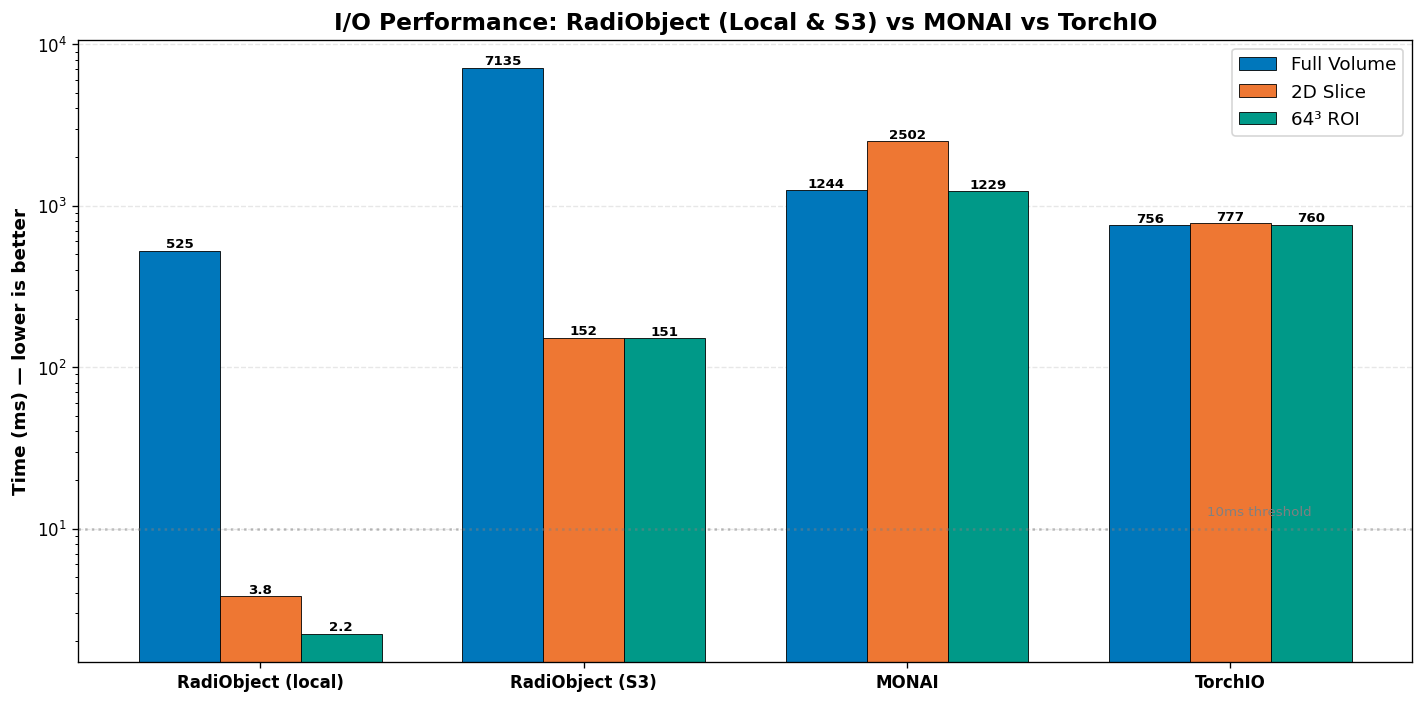


--- Speedup Summary (vs slowest) ---
Full Volume | RadiObject (local): 13.6x
Full Volume | RadiObject (S3): 1.0x
Full Volume | MONAI: 5.7x
Full Volume | TorchIO: 9.4x
2D Slice | RadiObject (local): 655.9x
2D Slice | RadiObject (S3): 16.5x
2D Slice | MONAI: 1.0x
2D Slice | TorchIO: 3.2x
64³ ROI | RadiObject (local): 553.5x
64³ ROI | RadiObject (S3): 8.1x
64³ ROI | MONAI: 1.0x
64³ ROI | TorchIO: 1.6x


In [28]:
# HERO CHART: Consolidated Backend Comparison
# Shows all operations across all backends in one visualization


def create_hero_chart():
    """Create consolidated comparison chart across all backends and operations."""

    # Collect data for key operations
    operations = {
        "Full Volume": "full_volume",
        "2D Slice": "slice_2d",
        "64³ ROI": "roi_3d",
    }

    # Include S3 backend if benchmarks were run
    has_s3_results = any(r.scenario == "s3" and r.framework == "RadiObject" for r in all_results)

    backends = [
        ("RadiObject (local)", "RadiObject", "local"),
    ]
    if has_s3_results:
        backends.append(("RadiObject (S3)", "RadiObject", "s3"))
    backends.extend(
        [
            ("MONAI", "MONAI", "local"),
            ("TorchIO", "TorchIO", "local"),
        ]
    )

    # Build data matrix
    data = {op: [] for op in operations}
    backend_labels = []

    for label, framework, scenario in backends:
        backend_labels.append(label)
        for op_name, bench_name in operations.items():
            result = next(
                (
                    r
                    for r in all_results
                    if r.benchmark_name == bench_name
                    and r.framework == framework
                    and r.scenario == scenario
                    and (r.tiling_strategy in ["", "axial", "isotropic"])
                ),
                None,
            )
            # For RadiObject, prefer optimal tiling per operation
            if framework == "RadiObject":
                if bench_name == "slice_2d":
                    result = next(
                        (
                            r
                            for r in all_results
                            if r.benchmark_name == bench_name
                            and r.framework == framework
                            and r.tiling_strategy == "axial"
                            and r.scenario == scenario
                        ),
                        result,
                    )
                elif bench_name == "roi_3d":
                    result = next(
                        (
                            r
                            for r in all_results
                            if r.benchmark_name == bench_name
                            and r.framework == framework
                            and r.tiling_strategy == "isotropic"
                            and r.scenario == scenario
                        ),
                        result,
                    )

            data[op_name].append(result.time_mean_ms if result else 0)

    # Create grouped bar chart
    n_backends = len(backend_labels)
    fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(n_backends)
    width = 0.25
    multiplier = 0

    colors = ["#0077BB", "#EE7733", "#009988"]

    for i, (op_name, times) in enumerate(data.items()):
        offset = width * multiplier
        bars = ax.bar(
            x + offset,
            times,
            width,
            label=op_name,
            color=colors[i],
            edgecolor="black",
            linewidth=0.5,
        )

        # Add value labels
        for bar, val in zip(bars, times):
            if val > 0:
                height = bar.get_height()
                label = f"{val:.0f}" if val >= 10 else f"{val:.1f}"
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height,
                    label,
                    ha="center",
                    va="bottom",
                    fontsize=8,
                    fontweight="bold",
                )
        multiplier += 1

    ax.set_ylabel("Time (ms) — lower is better", fontweight="bold")
    title = "I/O Performance: RadiObject vs MONAI vs TorchIO"
    if has_s3_results:
        title = "I/O Performance: RadiObject (Local & S3) vs MONAI vs TorchIO"
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xticks(x + width)
    ax.set_xticklabels(backend_labels, fontweight="bold")
    ax.legend(loc="upper right")
    ax.set_yscale("log")
    ax.grid(axis="y", alpha=0.3, linestyle="--")
    ax.set_axisbelow(True)

    # Add speedup annotations
    ax.axhline(y=10, color="gray", linestyle=":", alpha=0.5)
    ax.text(n_backends - 0.5, 12, "10ms threshold", fontsize=8, color="gray", ha="right")

    plt.tight_layout()
    filepath = ASSETS_DIR / "benchmark_hero.png"
    plt.savefig(filepath, dpi=300)
    print(f"Saved: {filepath}")
    plt.show()

    # Print speedup summary
    print("\n--- Speedup Summary (vs slowest) ---")
    for op_name, times in data.items():
        if all(t > 0 for t in times):
            max_time = max(times)
            for label, t in zip(backend_labels, times):
                speedup = max_time / t
                print(f"{op_name} | {label}: {speedup:.1f}x")


create_hero_chart()

In [29]:
def plot_bar_comparison(
    data: dict[str, float],
    title: str,
    ylabel: str,
    filename: str,
    errors: dict[str, float] | None = None,
    color_key: str = "framework",
):
    """Create a bar chart comparing frameworks."""
    labels = list(data.keys())
    values = list(data.values())

    # Determine colors
    if color_key == "framework":
        colors = [COLORS.get(l.split()[0], "#999999") for l in labels]
    else:
        colors = [COLORS.get(l.lower(), "#999999") for l in labels]

    error_vals = [errors.get(l, 0) for l in labels] if errors else None

    fig, ax = plt.subplots(figsize=(8, 5))
    bars = ax.bar(
        labels,
        values,
        yerr=error_vals,
        capsize=5,
        color=colors,
        edgecolor="black",
        linewidth=1,
    )

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(axis="y", alpha=0.3, linestyle="--")
    ax.set_axisbelow(True)

    # Rotate labels if needed
    if len(labels) > 4 or max(len(l) for l in labels) > 15:
        plt.xticks(rotation=30, ha="right")

    # Add value labels
    max_val = max(values) if values else 1
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + (max_val * 0.02),
            f"{val:.1f}",
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight="bold",
        )

    plt.tight_layout()
    filepath = ASSETS_DIR / filename
    plt.savefig(filepath)
    print(f"Saved: {filepath}")
    plt.show()
    return fig

Saved: ../assets/benchmark/disk_space_comparison.png


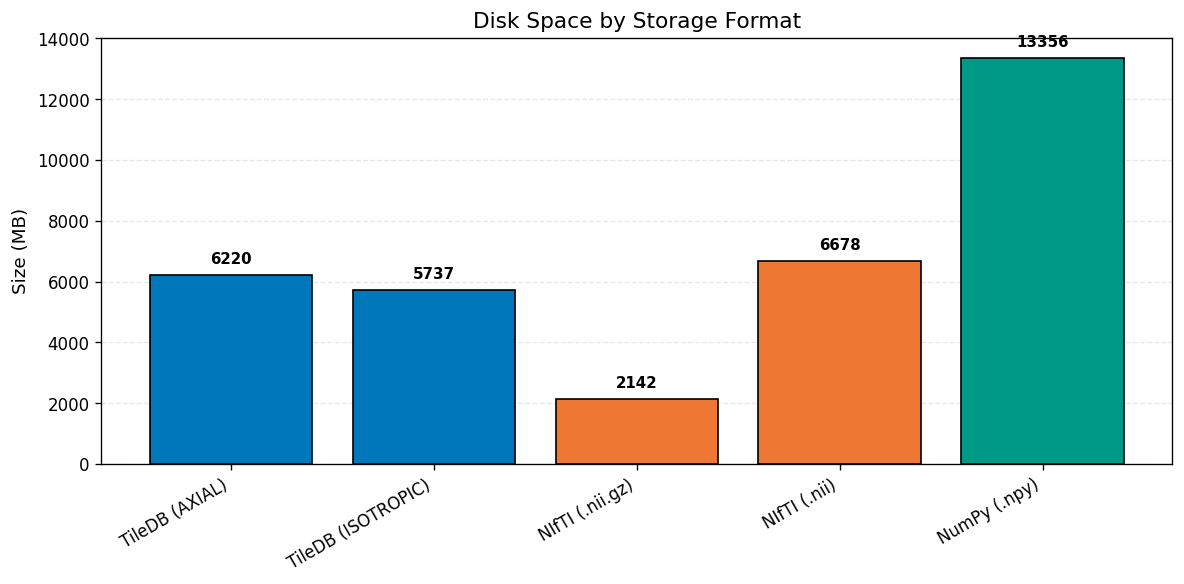

In [30]:
# Plot: Disk Space Comparison
if disk_space_results:
    data = {r.format_name: r.size_mb for r in disk_space_results}

    fig, ax = plt.subplots(figsize=(10, 5))
    labels = list(data.keys())
    values = list(data.values())
    colors = ["#0077BB", "#0077BB", "#EE7733", "#EE7733", "#009988"]

    bars = ax.bar(labels, values, color=colors[: len(labels)], edgecolor="black", linewidth=1)

    ax.set_ylabel("Size (MB)")
    ax.set_title("Disk Space by Storage Format")
    ax.grid(axis="y", alpha=0.3, linestyle="--")
    ax.set_axisbelow(True)
    plt.xticks(rotation=30, ha="right")

    # Add value labels
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + (max(values) * 0.02),
            f"{val:.0f}",
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight="bold",
        )

    plt.tight_layout()
    filepath = ASSETS_DIR / "disk_space_comparison.png"
    plt.savefig(filepath)
    print(f"Saved: {filepath}")
    plt.show()

Saved: ../assets/benchmark/format_overhead.png


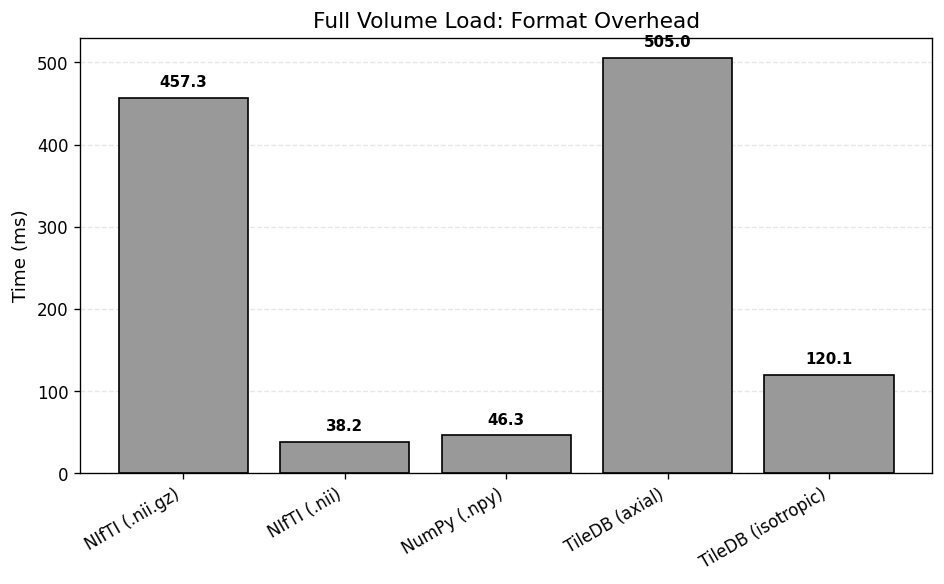

In [31]:
# Plot: Format Overhead Comparison
format_results = [r for r in all_results if r.benchmark_name == "format_comparison"]
if format_results:
    data = {}
    for r in format_results:
        if r.storage_format == "nifti_gz":
            label = "NIfTI (.nii.gz)"
        elif r.storage_format == "nifti":
            label = "NIfTI (.nii)"
        elif r.storage_format == "numpy":
            label = "NumPy (.npy)"
        elif r.storage_format == "tiledb":
            label = f"TileDB ({r.tiling_strategy})"
        else:
            label = r.storage_format
        data[label] = r.time_mean_ms

    plot_bar_comparison(
        data, "Full Volume Load: Format Overhead", "Time (ms)", "format_overhead.png"
    )

Saved: ../assets/benchmark/memory_by_backend.png


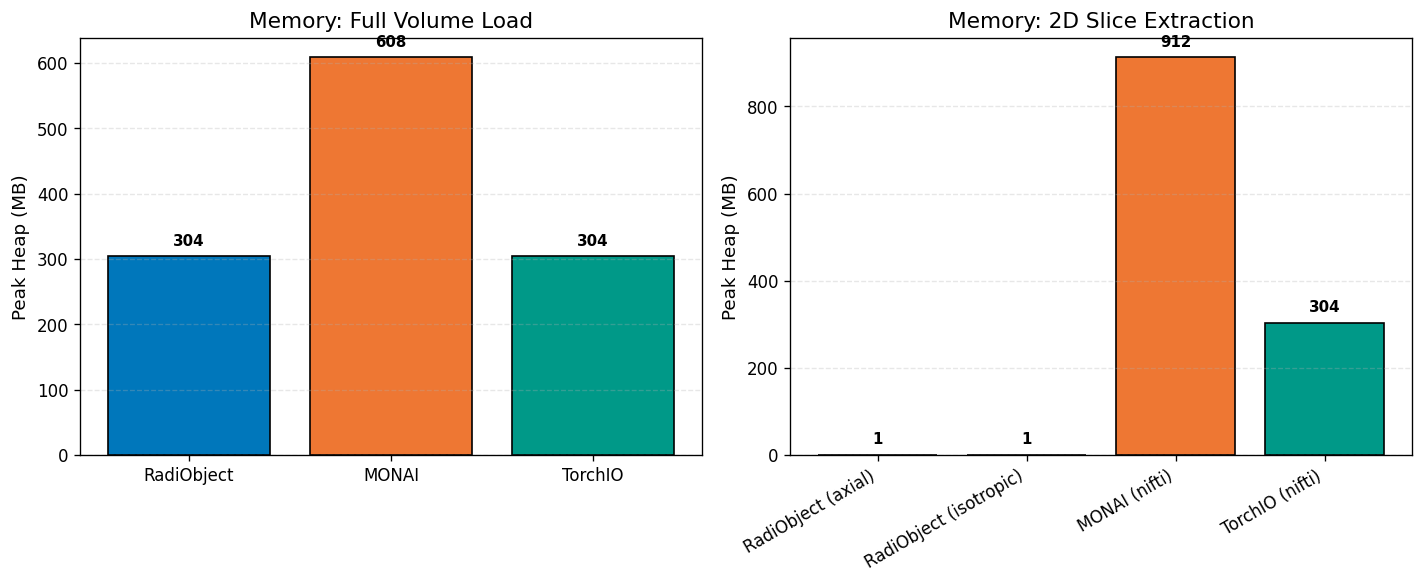

In [32]:
# Plot: Memory by Backend (Heap comparison)
memory_results = [
    r
    for r in all_results
    if r.benchmark_name in ["full_volume", "slice_2d"] and r.scenario == "local"
]
if memory_results:
    # Group by benchmark type
    full_vol = [r for r in memory_results if r.benchmark_name == "full_volume"]
    slice_2d = [r for r in memory_results if r.benchmark_name == "slice_2d"]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Full volume memory
    if full_vol:
        data = {r.framework: r.peak_heap_mb for r in full_vol if r.peak_heap_mb > 0}
        if data:
            ax = axes[0]
            labels = list(data.keys())
            values = list(data.values())
            colors = [COLORS.get(l, "#999999") for l in labels]
            bars = ax.bar(labels, values, color=colors, edgecolor="black", linewidth=1)
            ax.set_ylabel("Peak Heap (MB)")
            ax.set_title("Memory: Full Volume Load")
            ax.grid(axis="y", alpha=0.3, linestyle="--")
            for bar, val in zip(bars, values):
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + (max(values) * 0.02),
                    f"{val:.0f}",
                    ha="center",
                    va="bottom",
                    fontsize=9,
                    fontweight="bold",
                )

    # Slice extraction memory
    if slice_2d:
        data = {
            f"{r.framework} ({r.tiling_strategy or 'nifti'})": r.peak_heap_mb
            for r in slice_2d
            if r.peak_heap_mb > 0
        }
        if data:
            ax = axes[1]
            labels = list(data.keys())
            values = list(data.values())
            colors = [COLORS.get(l.split()[0], "#999999") for l in labels]
            bars = ax.bar(labels, values, color=colors, edgecolor="black", linewidth=1)
            ax.set_ylabel("Peak Heap (MB)")
            ax.set_title("Memory: 2D Slice Extraction")
            ax.grid(axis="y", alpha=0.3, linestyle="--")
            plt.xticks(rotation=30, ha="right")
            for bar, val in zip(bars, values):
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + (max(values) * 0.02),
                    f"{val:.0f}",
                    ha="center",
                    va="bottom",
                    fontsize=9,
                    fontweight="bold",
                )

    plt.tight_layout()
    filepath = ASSETS_DIR / "memory_by_backend.png"
    plt.savefig(filepath)
    print(f"Saved: {filepath}")
    plt.show()

Saved: ../assets/benchmark/full_volume_load.png


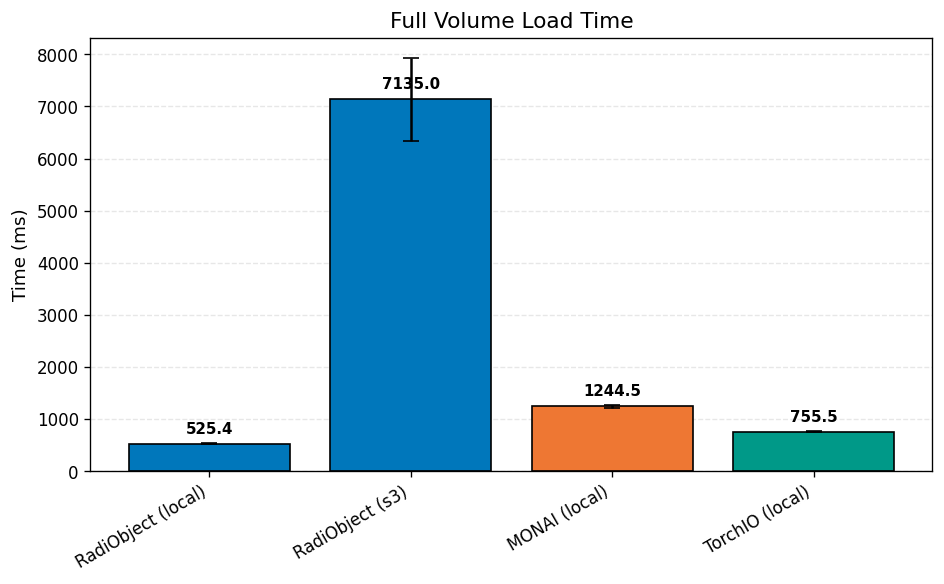

In [33]:
# Plot: Full Volume Load Time
full_volume_results = [r for r in all_results if r.benchmark_name == "full_volume"]
if full_volume_results:
    data = {}
    errors = {}
    for r in full_volume_results:
        label = f"{r.framework} ({r.scenario})"
        data[label] = r.time_mean_ms
        errors[label] = r.time_std_ms

    plot_bar_comparison(data, "Full Volume Load Time", "Time (ms)", "full_volume_load.png", errors)

Saved: ../assets/benchmark/slice_extraction.png


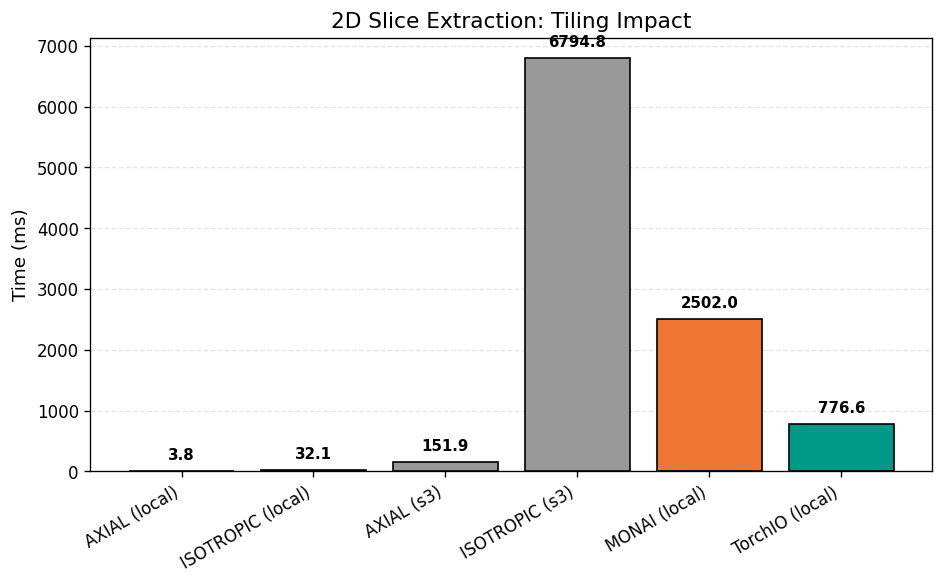

In [34]:
# Plot: Slice Extraction (Tiling Comparison)
slice_results = [r for r in all_results if r.benchmark_name == "slice_2d"]
if slice_results:
    data = {}
    for r in slice_results:
        if r.framework == "RadiObject":
            label = f"{r.tiling_strategy.upper()} ({r.scenario})"
        else:
            label = f"{r.framework} ({r.scenario})"
        data[label] = r.time_mean_ms

    plot_bar_comparison(
        data, "2D Slice Extraction: Tiling Impact", "Time (ms)", "slice_extraction.png"
    )

Saved: ../assets/benchmark/roi_extraction.png


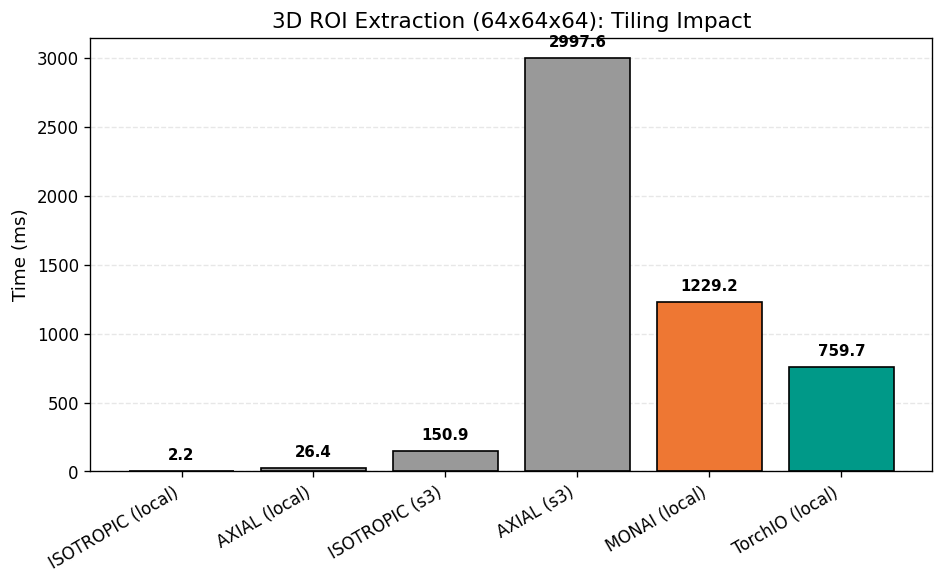

In [35]:
# Plot: ROI Extraction (Tiling Comparison)
roi_results = [r for r in all_results if r.benchmark_name == "roi_3d"]
if roi_results:
    data = {}
    for r in roi_results:
        if r.framework == "RadiObject":
            label = f"{r.tiling_strategy.upper()} ({r.scenario})"
        else:
            label = f"{r.framework} ({r.scenario})"
        data[label] = r.time_mean_ms

    plot_bar_comparison(
        data, "3D ROI Extraction (64x64x64): Tiling Impact", "Time (ms)", "roi_extraction.png"
    )

Saved: ../assets/benchmark/dataloader_throughput.png


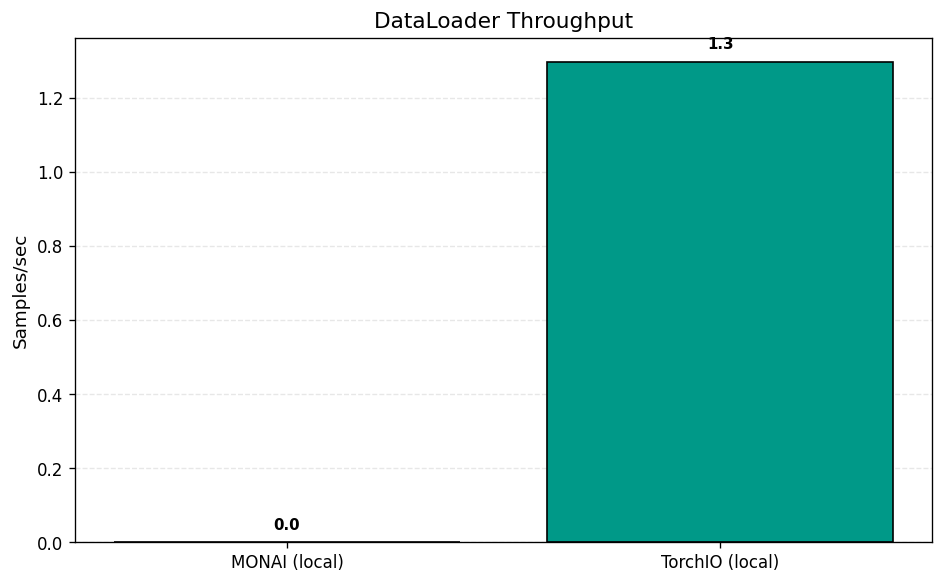

In [36]:
# Plot: DataLoader Throughput
throughput_results = [r for r in all_results if r.benchmark_name == "dataloader_throughput"]
if throughput_results:
    data = {}
    for r in throughput_results:
        label = f"{r.framework} ({r.scenario})"
        data[label] = r.throughput_samples_per_sec

    plot_bar_comparison(data, "DataLoader Throughput", "Samples/sec", "dataloader_throughput.png")

Saved: ../assets/benchmark/s3_vs_local_full.png


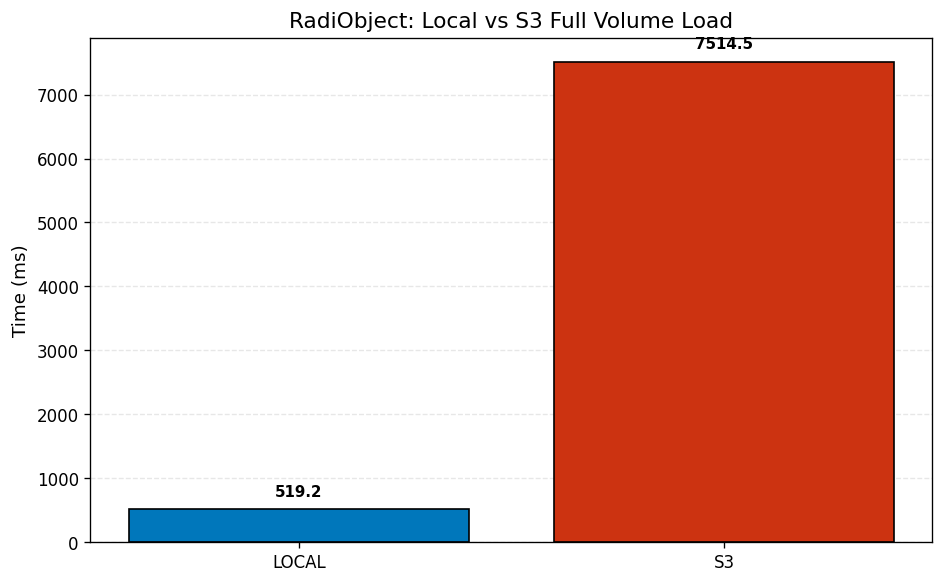

Saved: ../assets/benchmark/s3_vs_local_slice.png


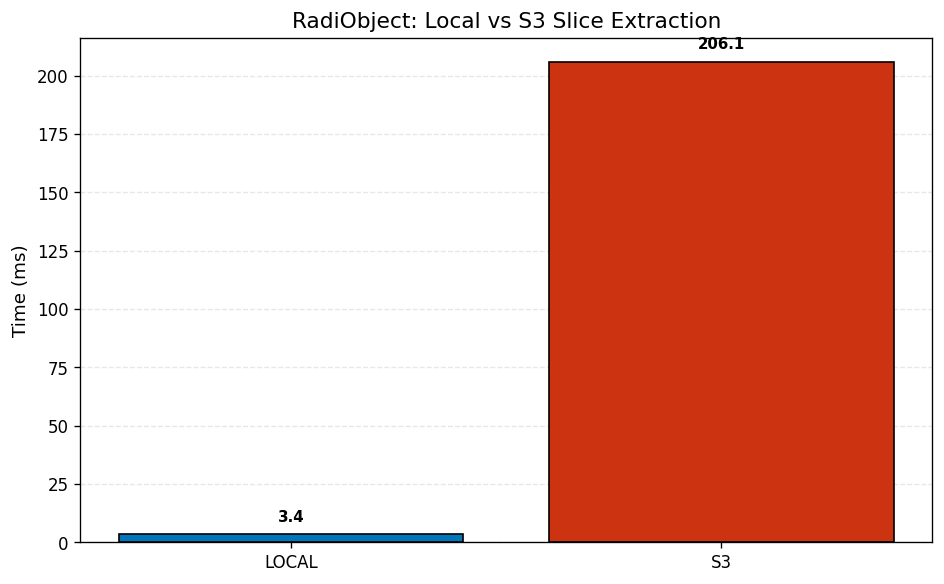

In [37]:
# Plot: S3 vs Local Comparison
s3_comp_results = [r for r in all_results if "s3_comparison" in r.benchmark_name]
if s3_comp_results:
    # Full volume comparison
    full_results = [r for r in s3_comp_results if "full" in r.benchmark_name]
    if len(full_results) >= 2:
        data = {r.scenario.upper(): r.time_mean_ms for r in full_results}
        plot_bar_comparison(
            data,
            "RadiObject: Local vs S3 Full Volume Load",
            "Time (ms)",
            "s3_vs_local_full.png",
            color_key="scenario",
        )

    # Slice comparison
    slice_results = [r for r in s3_comp_results if "slice" in r.benchmark_name]
    if len(slice_results) >= 2:
        data = {r.scenario.upper(): r.time_mean_ms for r in slice_results}
        plot_bar_comparison(
            data,
            "RadiObject: Local vs S3 Slice Extraction",
            "Time (ms)",
            "s3_vs_local_slice.png",
            color_key="scenario",
        )

## 9. Results Summary

In [38]:
# Build summary DataFrame
summary_rows = [r.to_dict() for r in all_results]
summary_df = pd.DataFrame(summary_rows)

# Display key columns
display_cols = [
    "framework",
    "benchmark_name",
    "scenario",
    "tiling_strategy",
    "time_mean_ms",
    "time_std_ms",
    "cpu_percent_mean",
    "peak_heap_mb",
    "throughput_samples_per_sec",
]
existing_cols = [c for c in display_cols if c in summary_df.columns]
display(summary_df[existing_cols])

,framework,benchmark_name,scenario,tiling_strategy,time_mean_ms,time_std_ms,cpu_percent_mean,peak_heap_mb,throughput_samples_per_sec
0,nibabel,format_comparison,local,,457.345,25.589,14.6,912.01,0.0
1,nibabel,format_comparison,local,,38.223,2.013,33.9,608.02,0.0
2,numpy,format_comparison,local,,46.325,0.626,43.1,608.01,0.0
3,RadiObject,format_comparison,local,axial,504.975,9.429,51.1,304.02,0.0
4,RadiObject,format_comparison,local,isotropic,120.080,1.582,65.9,304.01,0.0
5,RadiObject,full_volume,local,axial,525.436,9.730,67.1,304.01,0.0
6,RadiObject,full_volume,s3,axial,7134.961,790.591,17.7,304.01,0.0
7,MONAI,full_volume,local,,1244.491,25.750,10.0,608.19,0.0
8,TorchIO,full_volume,local,,755.517,5.360,21.3,304.01,0.0
9,RadiObject,slice_2d,local,axial,3.814,0.357,45.4,1.01,0.0


In [39]:
# Export results to JSON
results_json = {
    "timestamp": datetime.now().isoformat(),
    "config": {
        "batch_size": BATCH_SIZE,
        "patch_size": list(PATCH_SIZE),
        "num_workers": NUM_WORKERS,
        "n_warmup": N_WARMUP,
        "n_batches": N_BATCHES,
        "n_runs": N_RUNS,
        "random_seed": RANDOM_SEED,
        "s3_bucket": S3_BUCKET,
        "n_subjects": N_SUBJECTS_FOR_TILED,
    },
    "datasets": {
        "local_axial": LOCAL_AXIAL_URI,
        "local_isotropic": LOCAL_ISOTROPIC_URI,
        "nifti_compressed": str(NIFTI_COMPRESSED_DIR),
        "nifti_uncompressed": str(NIFTI_UNCOMPRESSED_DIR),
        "numpy": str(NUMPY_DIR),
        "s3_axial": S3_AXIAL_URI if radi_s3_axial else None,
        "s3_isotropic": S3_ISOTROPIC_URI if radi_s3_isotropic else None,
    },
    "disk_space": [r.to_dict() for r in disk_space_results],
    "benchmarks": [r.to_dict() for r in all_results],
}

results_path = ASSETS_DIR / "benchmark_results.json"
with open(results_path, "w") as f:
    json.dump(results_json, f, indent=2, default=str)

print(f"Results exported: {results_path}")

Results exported: ../assets/benchmark/benchmark_results.json


## 10. Conclusions

### Tiling Strategy Impact

| Operation | Optimal Tiling | Why |
|-----------|---------------|-----|
| 2D Axial Slice | AXIAL (z=1) | Reads exactly 1 tile per slice |
| 3D ROI (64x64x64) | ISOTROPIC (64^3) | Reads 1-8 tiles depending on alignment |

**Key Insight**: Choose tiling strategy based on your primary access pattern!

### When to Use Each Framework

| Use Case | Recommended Framework | Reason |
|----------|----------------------|--------|
| **S3/Cloud data** | RadiObject | Only option with native S3 support |
| **Partial volume reads** | RadiObject | TileDB tile-level access |
| **Large dataset exploration** | RadiObject | O(1) indexing, lazy views |
| **Multi-modal alignment** | RadiObject | Unified subject index |
| **Local NIfTI training** | MONAI/TorchIO | Optimized transforms |
| **Data augmentation** | TorchIO | Rich transform library |
| **Production DL pipelines** | MONAI | Comprehensive ecosystem |

### RadiObject's Sweet Spot

1. **Cloud-native workflows**: Train directly from S3 without downloading
2. **Interactive analysis**: Fast metadata queries and partial reads
3. **Large cohort studies**: Scale to 10,000+ subjects with O(1) operations
4. **Multi-modal data**: Unified index across T1w, FLAIR, CT, etc.

In [40]:
print("=" * 60)
print("BENCHMARK COMPLETE")
print("=" * 60)

print("\nDatasets:")
print(f"  Local AXIAL: {len(radi_local_axial) if radi_local_axial else 'N/A'} subjects")
print(f"  Local ISOTROPIC: {len(radi_local_isotropic) if radi_local_isotropic else 'N/A'} subjects")
print(f"  S3 AXIAL: {len(radi_s3_axial) if radi_s3_axial else 'N/A'} subjects")
print(f"  S3 ISOTROPIC: {len(radi_s3_isotropic) if radi_s3_isotropic else 'N/A'} subjects")
print(f"  NIfTI files: {len(nifti_paths) if nifti_paths else 0}")

print("\nConfiguration:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Patch size: {PATCH_SIZE}")
print(f"  Runs per benchmark: {N_RUNS}")

print("\nFramework Availability:")
print("  RadiObject: Available")
print(f"  MONAI: {'Available' if HAVE_MONAI else 'Not installed'}")
print(f"  TorchIO: {'Available' if HAVE_TORCHIO else 'Not installed'}")

print("\nGenerated Artifacts:")
for f in sorted(ASSETS_DIR.glob("*")):
    if not f.name.startswith("."):
        print(f"  {f.name}")

print("\n" + "=" * 60)

BENCHMARK COMPLETE

Datasets:
  Local AXIAL: 63 subjects
  Local ISOTROPIC: 63 subjects
  S3 AXIAL: 63 subjects
  S3 ISOTROPIC: 63 subjects
  NIfTI files: 20

Configuration:
  Batch size: 4
  Patch size: (64, 64, 64)
  Runs per benchmark: 10

Framework Availability:
  RadiObject: Available
  MONAI: Available
  TorchIO: Available

Generated Artifacts:
  benchmark_hero.png
  benchmark_results.json
  dataloader_throughput.png
  disk_space_comparison.png
  format_overhead.png
  full_volume_load.png
  memory_by_backend.png
  roi_extraction.png
  s3_vs_local_full.png
  s3_vs_local_slice.png
  slice_extraction.png

